# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 64 #32
TRAIN_SPLIT_RATIO = 0.99 #0.8 #0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 2 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83168/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
79770  1696462200000   1650.38   1651.35  1649.44    1649.80    368.3205   
79771  1696462500000   1649.80   1651.44  1649.80    1650.16    721.8377   
79772  1696462800000   1650.16   1650.16  1648.51    1648.54    263.2345   
79773  1696463100000   1648.55   1648.94  1648.54    1648.83    197.4250   
79774  1696463400000   1648.82   1648.83  1647.73    1647.74    107.6859   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.056586       1733.619316   
1      2023-01-01 00:05:00       1734.056586       1733.619316   
2      2023-01-01 00:10:00       1734.056586       1733.619316   
3      2023-01-01 00:15:00       1734.056586       1733.619316   
4      2023-01-01 00:20:00       1734.056586       1733.619316   
...                    ...               ...               ...   
79770  2023-10-04 23:30:00       1645.262500       1646.075000   
79771  2023-10-04 23:35:00       1645.060000       1646.075000   
79772  2023-10-04 23:40:00       1644.005000       1646.075000   
79773  2023-10-04 23:45:00       1644.165000       1646.075000   
79774  2023-10-04 23:50:00       1643.795000       1646.075000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
79770        1647.895  ...   NaN         NaN            NaN           NaN   
79771        1647.895  ...   NaN         NaN            NaN           NaN   
79772        1647.895  ...   NaN         NaN            NaN           NaN   
79773        1647.895  ...   NaN         NaN            NaN           NaN   
79774        1647.895  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
79770               NaN         0.0               NaN         0.0      0.0   
79771               NaN         0.0               NaN         0.0      0.0   
79772               NaN         0.0               NaN         0.0      0.0   
79773               NaN         0.0               NaN         0.0      0.0   
79774               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
79770   NaN  
79771   NaN  
79772   NaN  
79773   NaN  
79774   NaN  

[79775 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              79741
Event               79741
Country             79741
keep                79741
date                79741
Length: 65, dtype: int64

on 79775 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
79770  1696462200000   1650.38   1651.35  1649.44    1649.80    368.3205   
79771  1696462500000   1649.80   1651.44  1649.80    1650.16    721.8377   
79772  1696462800000   1650.16   1650.16  1648.51    1648.54    263.2345   
79773  1696463100000   1648.55   1648.94  1648.54    1648.83    197.4250   
79774  1696463400000   1648.82   1648.83  1647.73    1647.74    107.6859   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.056586       1733.619316   
1      2023-01-01 00:05:00       1734.056586       1733.619316   
2      2023-01-01 00:10:00       1734.056586       1733.619316   
3      2023-01-01 00:15:00       1734.056586       1733.619316   
4      2023-01-01 00:20:00       1734.056586       1733.619316   
...                    ...               ...               ...   
79770  2023-10-04 23:30:00       1645.262500       1646.075000   
79771  2023-10-04 23:35:00       1645.060000       1646.075000   
79772  2023-10-04 23:40:00       1644.005000       1646.075000   
79773  2023-10-04 23:45:00       1644.165000       1646.075000   
79774  2023-10-04 23:50:00       1643.795000       1646.075000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
79770        1647.895  ...   NaN         NaN            NaN           NaN   
79771        1647.895  ...   NaN         NaN            NaN           NaN   
79772        1647.895  ...   NaN         NaN            NaN           NaN   
79773        1647.895  ...   NaN         NaN            NaN           NaN   
79774        1647.895  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
79770               NaN         0.0               NaN         0.0      0.0   
79771               NaN         0.0               NaN         0.0      0.0   
79772               NaN         0.0               NaN         0.0      0.0   
79773               NaN         0.0               NaN         0.0      0.0   
79774               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
79770                  NaN  
79771                  NaN  
79772                  NaN  
79773                  NaN  
79774                  NaN  

[79775 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       4090
delta_event_real    4090
delta_event_pred    4090
Previous_num        4090
Actual_num          4090
Event               4090
Date                4090
Previous            4090
Consensus           4090
Actual              4090
Country             4090
Time (ET)           4090
keep                4090
date                4090
dtype: int64

on 79775 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
79770   1650.38   1651.35  1649.44    1649.80    368.3205   
79771   1649.80   1651.44  1649.80    1650.16    721.8377   
79772   1650.16   1650.16  1648.51    1648.54    263.2345   
79773   1648.55   1648.94  1648.54    1648.83    197.4250   
79774   1648.82   1648.83  1647.73    1647.74    107.6859   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.056586       1733.619316   
1      2023-01-01 00:05:00       1734.056586       1733.619316   
2      2023-01-01 00:10:00       1734.056586       1733.619316   
3      2023-01-01 00:15:00       1734.056586       1733.619316   
4      2023-01-01 00:20:00       1734.056586       1733.619316   
...                    ...               ...               ...   
79770  2023-10-04 23:30:00       1645.262500       1646.075000   
79771  2023-10-04 23:35:00       1645.060000       1646.075000   
79772  2023-10-04 23:40:00       1644.005000       1646.075000   
79773  2023-10-04 23:45:00       1644.165000       1646.075000   
79774  2023-10-04 23:50:00       1643.795000       1646.075000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710          1194.71  ...  1196.096667  1196.096667   
1            1194.710          1194.71  ...  1195.801420  1195.801420   
2            1194.710          1194.71  ...  1195.648641  1195.648641   
3            1194.710          1194.71  ...  1195.575250  1195.575250   
4            1194.710          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
79770        1647.895          1650.22  ...  1639.094103  1657.762241   
79771        1647.895          1650.22  ...  1639.099472  1657.752656   
79772        1647.895          1650.22  ...  1639.101680  1657.749459   
79773        1647.895          1650.65  ...  1639.103580  1657.745970   
79774        1647.895          1650.26  ...  1639.104876  1657.743559   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
79770  1774.396692  1628.863706   1724.291293         -0.447503 -0.045152   
79771  1774.389610  1628.865940   1724.290788         -0.445339 -0.044923   
79772  1774.384845  1628.865276   1724.290601         -0.455072 -0.045950   
79773  1774.378061  1628.865539   1724.290460         -0.453332 -0.045766   
79774  1774.371751  1628.865722   1724.290382         -0.459881 -0.046458   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205178e+08      538686.0       18.557331  
1      1.205178e+08      538686.0       18.557331  
2      1.205178e+08      538686.0       18.557331  
3      1.205178e+08      538686.0       18.557331  
4      1.205178e+08      538686.0       18.557331  
...             ...           ...             ...  
79770  1.202407e+08      452018.0       17.707381  
79771  1.202407e+08      452018.0       17.707381  
79772  1.202407e+08      452018.0       17.707381  
79773  1.202407e+08      452018.0       17.707381  
79774  1.202407e+08      452018.0       17.707381  

[79775 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
79770  4.719  4263.750000  106.774002
79771  4.719  4263.750000  106.774002
79772  4.719  4263.750000  106.774002
79773  4.719  4263.750000  106.774002
79774  4.719  4263.750000  106.774002

[79775 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

79775

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

78977

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
79770  1696462200000   1650.38   1651.35  1649.44    1649.80    368.3205   
79771  1696462500000   1649.80   1651.44  1649.80    1650.16    721.8377   
79772  1696462800000   1650.16   1650.16  1648.51    1648.54    263.2345   
79773  1696463100000   1648.55   1648.94  1648.54    1648.83    197.4250   
79774  1696463400000   1648.82   1648.83  1647.73    1647.74    107.6859   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.056586       1733.619316   
1      2023-01-01 00:05:00       1734.056586       1733.619316   
2      2023-01-01 00:10:00       1734.056586       1733.619316   
3      2023-01-01 00:15:00       1734.056586       1733.619316   
4      2023-01-01 00:20:00       1734.056586       1733.619316   
...                    ...               ...               ...   
79770  2023-10-04 23:30:00       1645.262500       1646.075000   
79771  2023-10-04 23:35:00       1645.060000       1646.075000   
79772  2023-10-04 23:40:00       1644.005000       1646.075000   
79773  2023-10-04 23:45:00       1644.165000       1646.075000   
79774  2023-10-04 23:50:00       1643.795000       1646.075000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
79770        1647.895  ...         NaN            NaN           NaN   
79771        1647.895  ...         NaN            NaN           NaN   
79772        1647.895  ...         NaN            NaN           NaN   
79773        1647.895  ...         NaN            NaN           NaN   
79774        1647.895  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
79770               NaN         0.0               NaN         0.0      0.0   
79771               NaN         0.0               NaN         0.0      0.0   
79772               NaN         0.0               NaN         0.0      0.0   
79773               NaN         0.0               NaN         0.0      0.0   
79774               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
79770                  NaN  False  
79771                  NaN  False  
79772                  NaN  False  
79773                  NaN  False  
79774                  NaN  False  

[79775 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
78973  1696223100000   1726.19   1726.20  1725.15    1725.67    261.8448   
78974  1696223400000   1725.66   1726.38  1725.50    1725.99    290.1047   
78975  1696223700000   1725.99   1727.37  1725.98    1727.36    451.0674   
78976  1696224000000   1727.36   1728.85  1727.36    1728.35    671.4109   
78977  1696224300000   1728.35   1728.78  1728.03    1728.03    578.2673   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.056586       1733.619316   
1      2023-01-01 00:05:00       1734.056586       1733.619316   
2      2023-01-01 00:10:00       1734.056586       1733.619316   
3      2023-01-01 00:15:00       1734.056586       1733.619316   
4      2023-01-01 00:20:00       1734.056586       1733.619316   
...                    ...               ...               ...   
78973  2023-10-02 05:05:00       1725.225000       1727.615000   
78974  2023-10-02 05:10:00       1725.225000       1727.615000   
78975  2023-10-02 05:15:00       1725.225000       1727.615000   
78976  2023-10-02 05:20:00       1725.225000       1727.615000   
78977  2023-10-02 05:25:00       1725.225000       1727.615000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
78973         1729.26  ...         NaN            NaN           NaN   
78974         1729.26  ...         NaN            NaN           NaN   
78975         1729.26  ...         NaN            NaN           NaN   
78976         1729.26  ...         NaN            NaN           NaN   
78977         1729.26  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
78973               NaN         0.0               NaN         0.0      0.0   
78974               NaN         0.0               NaN         0.0      0.0   
78975               NaN         0.0               NaN         0.0      0.0   
78976               NaN         0.0               NaN         0.0      0.0   
78977               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
78973                  NaN   True  
78974                  NaN   True  
78975                  NaN   True  
78976                  NaN   True  
78977                  NaN   True  

[78978 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
78978  1696224600000   1728.04   1728.04  1723.08    1723.28   1270.2216   
78979  1696224900000   1723.29   1724.16  1721.00    1721.83   1952.5409   
78980  1696225200000   1721.83   1722.48  1712.27    1717.65   5298.3642   
78981  1696225500000   1717.65   1719.57  1716.18    1716.63   1856.7900   
78982  1696225800000   1716.64   1718.09  1716.00    1717.43   1343.4849   
...              ...       ...       ...      ...        ...         ...   
79770  1696462200000   1650.38   1651.35  1649.44    1649.80    368.3205   
79771  1696462500000   1649.80   1651.44  1649.80    1650.16    721.8377   
79772  1696462800000   1650.16   1650.16  1648.51    1648.54    263.2345   
79773  1696463100000   1648.55   1648.94  1648.54    1648.83    197.4250   
79774  1696463400000   1648.82   1648.83  1647.73    1647.74    107.6859   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
78978  2023-10-02 05:30:00         1725.5325          1727.215   
78979  2023-10-02 05:35:00         1725.9475          1727.215   
78980  2023-10-02 05:40:00         1726.1225          1727.215   
78981  2023-10-02 05:45:00         1726.4775          1727.215   
78982  2023-10-02 05:50:00         1728.7475          1727.215   
...                    ...               ...               ...   
79770  2023-10-04 23:30:00         1645.2625          1646.075   
79771  2023-10-04 23:35:00         1645.0600          1646.075   
79772  2023-10-04 23:40:00         1644.0050          1646.075   
79773  2023-10-04 23:45:00         1644.1650          1646.075   
79774  2023-10-04 23:50:00         1643.7950          1646.075   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
78978        1728.250  ...         NaN            NaN           NaN   
78979        1727.210  ...         NaN            NaN           NaN   
78980        1722.845  ...         NaN            NaN           NaN   
78981        1722.845  ...         NaN            NaN           NaN   
78982        1721.235  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
79770        1647.895  ...         NaN            NaN           NaN   
79771        1647.895  ...         NaN            NaN           NaN   
79772        1647.895  ...         NaN            NaN           NaN   
79773        1647.895  ...         NaN            NaN           NaN   
79774        1647.895  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
78978               NaN         0.0               NaN         0.0      0.0   
78979               NaN         0.0               NaN         0.0      0.0   
78980               NaN         0.0               NaN         0.0      0.0   
78981               NaN         0.0               NaN         0.0      0.0   
78982               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
79770               NaN         0.0               NaN         0.0      0.0   
79771               NaN         0.0               NaN         0.0      0.0   
79772               NaN         0.0               NaN         0.0      0.0   
79773               NaN         0.0               NaN         0.0      0.0   
79774               NaN         0.0               NaN         0.0      0.0   

       date  train  
78978   NaN  False  
78979   NaN  False  
78980   NaN  False  
78981   NaN  False  
78982   NaN  False  
...     ...    ...  
79770   NaN  False  
79771   NaN  False  
79772   NaN  False  
79773   NaN  False  
79774   NaN  False  

[797 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(78891, 72, 102) (78891, 15)
(710, 72, 102) (710, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.0002432 , 1.00001158, 0.99972784, 0.9993862 , 0.99935725,
       0.99956571, 0.9989577 , 0.99904456, 0.99977996, 0.99964099,
       0.99956571, 0.99925881, 0.99944411, 1.00023741, 1.00081068])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99990748, 0.99860065, 0.99884351, ..., 0.99816696, 0.99786049,
        0.99804553],
       [0.99869304, 0.99893593, 0.99870461, ..., 0.99795282, 0.99813788,
        0.99893015],
       [1.0002432 , 1.00001158, 0.99972784, ..., 0.99944411, 1.00023741,
        1.00081068]])

In [39]:
seq_y

array([1.0002432 , 1.00001158, 0.99972784, 0.9993862 , 0.99935725,
       0.99956571, 0.9989577 , 0.99904456, 0.99977996, 0.99964099,
       0.99956571, 0.99925881, 0.99944411, 1.00023741, 1.00081068])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99990748, 0.99860065, 0.99884351, ..., 0.99816696, 0.99786049,
        0.99804553],
       [0.99869304, 0.99893593, 0.99870461, ..., 0.99795282, 0.99813788,
        0.99893015],
       [1.0002432 , 1.00001158, 0.99972784, ..., 0.99944411, 1.00023741,
        1.00081068]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(78891, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(78891, 72, 102) (78891, 15)
(710, 72, 102) (710, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99990748, 0.99860065, 0.99884351, ..., 0.99816696, 0.99786049,
        0.99804553],
       [0.99869304, 0.99893593, 0.99870461, ..., 0.99795282, 0.99813788,
        0.99893015],
       [1.0002432 , 1.00001158, 0.99972784, ..., 0.99944411, 1.00023741,
        1.00081068]])

In [47]:
np.mean(y_train_sca)

-1.4426739023360491e-05

In [48]:
np.std(y_train_sca)

0.9999716612899623

In [49]:
np.mean(y_test_sca)

-0.14313844560800967

In [50]:
np.std(y_test_sca)

0.8816412745582557

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1734.056586       1733.619316   
1    1195.38   1196.31   1196.69  1194.90       1734.056586       1733.619316   
2    1194.55   1195.38   1195.81  1194.55       1734.056586       1733.619316   
3    1195.98   1194.55   1195.98  1194.31       1734.056586       1733.619316   
4    1196.06   1195.98   1196.37  1195.97       1734.056586       1733.619316   
5    1196.61   1196.06   1196.70  1196.06       1734.056586       1733.619316   
6    1194.36   1196.62   1196.62  1193.72       1734.056586       1733.619316   
7    1194.22   1194.37   1194.43  1192.72       1734.056586       1733.619316   
8    1193.64   1194.22   1194.22  1193.02       1734.056586       1733.619316   
9    1194.64   1193.64   1195.06  1193.63       1734.056586       1733.619316   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1736.579636   
1         1194.71          1194.71           1736.579636   
2         1194.71          1194.71           1736.579636   
3         1194.71          1194.71           1736.579636   
4         1194.71          1194.71           1736.579636   
5         1194.71          1194.71           1736.579636   
6         1194.71          1194.71           1736.579636   
7         1194.71          1194.71           1736.579636   
8         1194.71          1194.71           1736.579636   
9         1194.71          1194.71           1736.579636   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
1           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
2           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
3           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
4           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
5           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
6           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
7           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
8           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   
9           1729.455279  ...  1.205178e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(5680152, 102)

In [57]:
X_train[:,-1,:].shape

(78891, 102)

In [58]:
X_test[:,-1,:].shape

(710, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.015733 -0.009791 -0.062011  0.081794         -0.042742   
1       0.015733 -0.037483 -0.073990  0.054022         -0.075528   
2       0.015733  0.025840 -0.052038  0.089744         -0.069149   
3       0.015733  0.107048  0.016881  0.096681         -0.000512   
4       0.015733 -0.063221 -0.071994  0.029201         -0.042189   
...          ...       ...       ...       ...               ...   
79596   0.015733  0.057653 -0.032930  0.079030          0.106318   
79597   0.015733  0.027452 -0.062660  0.050898          0.060164   
79598   0.015733  0.102307  0.022261  0.108599          0.122126   
79599   0.015733 -0.049509 -0.074263  0.042953          0.045725   
79600   0.015733 -0.154997 -0.073540 -0.062843         -0.074453   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.017312       -0.144613        -0.037498   
1             -0.019721       -0.175675        -0.070156   
2             -0.013663       -0.161280        -0.036010   
3              0.047637       -0.076758         0.052810   
4             -0.006258       -0.151070        -0.025281   
...                 ...             ...              ...   
79596         -0.015551        0.060655         0.130287   
79597         -0.007724        0.071470         0.134552   
79598          0.051030        0.152645         0.149182   
79599          0.006467        0.091076         0.074632   
79600         -0.109361       -0.068953        -0.090478   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.559054              7.986702  ...  0.366439  1.366070   
1                  8.546430              7.974858  ...  0.000387  1.414254   
2                  8.548495              7.976796  ...  0.000387  1.414254   
3                  8.569393              7.996401  ...  0.000387  1.414254   
4                  8.551019              7.979164  ...  0.000387  1.414254   
...                     ...                   ...  ...       ...       ...   
79596              0.752924              0.466484  ...  1.225222 -0.706909   
79597              0.754834              0.470635  ...  1.225222 -0.706909   
79598              0.769170              0.492598  ...  1.225222 -0.706909   
79599              0.758297              0.482500  ...  1.225222 -0.706909   
79600              0.730035              0.456253  ...  1.225222 -0.706909   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.878953    -1.101928          1.378620          0.284112 -0.053482   
1         0.878953    -1.101928          1.378620          0.284112 -0.053482   
2         0.878953    -1.101928          1.378620          0.284112 -0.053482   
3         0.878953    -1.101928          1.378620          0.284112 -0.053482   
4         0.878953    -1.101928          1.378620          0.284112 -0.053482   
...            ...          ...               ...               ...       ...   
79596    -0.317801     1.381879          0.968315          1.025562 -0.053482   
79597    -0.317801     1.381879          0.968315          1.025562 -0.053482   
79598    -0.317801     1.381879          0.968315          1.025562 -0.053482   
79599    -0.317801     1.381879          0.968315          1.025562 -0.053482   
79600    -0.317801     1.381879          0.968315          1.025562 -0.053482   

       event_pred  event_real  TRAIN  
0             0.0         0.0    1.0  
1             0.0         0.0    1.0  
2             0.0         0.0    1.0  
3             0.0         0.0    1.0  
4             0.0         0.0    1.0  
...           ...         ...    ...  
79596         0.0         0.0    0.0  
79597         0.0         0.0    0.0  
79598         0.0         0.0    0.0  
79599         0.0         0.0    0.0  
79600         0.0         0.0    0.0  

[79601 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  7.889100e+04  78891.000000  78891.000000  78891.000000   
mean   1.573277e-02      0.015520      0.015728      0.015495   
std    7.296293e-15      0.171651      0.135231      0.133362   
min    1.573277e-02     -5.713986     -0.074988     -5.658654   
25%    1.573277e-02     -0.046943     -0.058988     -0.011703   
50%    1.573277e-02      0.015946     -0.021213      0.053829   
75%    1.573277e-02      0.076894      0.042759      0.091989   
max    1.573277e-02     11.138588     11.377726      0.108599   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      78891.000000      78891.000000    78891.000000     78891.000000   
mean           0.008397          0.007782        0.014440         0.015293   
std            0.637642          0.688628        0.364292         0.233412   
min           -5.885802         -6.084726       -4.721270        -3.942013   
25%           -0.202510         -0.222837       -0.132679        -0.080469   
50%            0.020460          0.023727        0.026189         0.019930   
75%            0.235174          0.273277        0.175502         0.118412   
max            9.840287         10.086528        6.573033         6.141686   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          78891.000000          78891.000000  ...  78891.000000   
mean              -0.001706             -0.001657  ...      0.000246   
std                0.973428              0.977343  ...      1.000172   
min               -3.543972             -3.039595  ...     -1.413932   
25%               -0.392484             -0.450343  ...     -0.999688   
50%                0.003722             -0.021165  ...      0.000387   
75%                0.286588              0.376663  ...      1.000461   
max                8.587100              8.013014  ...      1.414705   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  78891.000000  78891.000000  78891.000000      78891.000000   
mean      -0.000200      0.000296      0.000429          0.000049   
std        0.999840      1.000274      0.999739          0.999983   
min       -1.413964     -1.277524     -1.374939         -1.416683   
25%       -0.999781     -1.277524     -1.101928         -0.949461   
50%        0.000145     -0.317801      0.003470         -0.076100   
75%        1.000071      0.878953      1.108868          0.968315   
max        1.414254      1.411559      1.381879          1.407526   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      78891.000000  78891.000000  7.889100e+04  7.889100e+04  78891.0  
mean           0.000141     -0.000003 -3.602655e-19  3.602655e-19      1.0  
std            1.000029      0.999975  9.999746e-01  9.999746e-01      0.0  
min           -1.417344     -0.053482 -7.021663e+01 -7.021663e+01      1.0  
25%           -1.027555     -0.053482  0.000000e+00  0.000000e+00      1.0  
50%           -0.000997     -0.053482  0.000000e+00  0.000000e+00      1.0  
75%            1.025562     -0.053482  0.000000e+00  0.000000e+00      1.0  
max            1.415351     18.697712  7.021663e+01  7.021663e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  7.100000e+02  710.000000  710.000000  710.000000        710.000000   
mean   1.573277e-02    0.024632    0.011967    0.017523          0.201471   
std    1.041568e-17    0.164669    0.134720    0.113502          0.501797   
min    1.573277e-02   -0.669939   -0.074988   -1.016166         -0.775974   
25%    1.573277e-02   -0.049057   -0.056365   -0.011463         -0.129955   
50%    1.573277e-02    0.019521   -0.017081    0.045302          0.091182   
75%    1.573277e-02    0.085170    0.037074    0.088497          0.427919   
max    1.573277e-02    2.539614    2.469931    0.108599          2.289990   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        710.000000      710.000000       710.000000   
mean           0.249341        0.056739         0.027100   
std            0.591250        0.287384         0.196828   
min           -0.720450       -0.891716        -0.710012   
25%           -0.119552       -0.132718        -0.088265   
50%            0.090053        0.043774         0.026905   
75%            0.491441        0.214517         0.135189   
max            2.733552        1.331990         1.048736   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            710.000000            710.000000  ...  710.000000   
mean               0.299209             -0.059115  ...   -0.068701   
std                0.422646              0.378650  ...    0.993551   
min               -0.819082             -0.987317  ...   -1.413932   
25%                0.102536             -0.261600  ...   -0.999688   
50%                0.252531             -0.143657  ...    0.000387   
75%                0.728315              0.313566  ...    1.000461   
max                0.911931              0.542442  ...    1.414705   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  710.000000   710.000000   710.000000        710.000000   
mean    -0.166623     0.535436     0.977982          1.112879   
std      0.991486     0.699771     0.521124          0.124922   
min     -1.413964    -0.317801     0.003470          0.968315   
25%     -1.224509    -0.317801     1.108868          0.968315   
50%     -0.365853     0.878953     1.108868          1.154426   
75%      0.707200     0.878953     1.381879          1.154426   
max      1.414254     1.411559     1.381879          1.293086   

       day_in_month_sin       day_off  event_pred  event_real  TRAIN  
count        710.000000  7.100000e+02       710.0       710.0  710.0  
mean           0.837824 -5.348248e-02         0.0         0.0    0.0  
std            0.174816  5.485591e-16         0.0         0.0    0.0  
min            0.557548 -5.348248e-02         0.0         0.0    0.0  
25%            0.808118 -5.348248e-02         0.0         0.0    0.0  
50%            0.808118 -5.348248e-02         0.0         0.0    0.0  
75%            1.025562 -5.348248e-02         0.0         0.0    0.0  
max            1.025562 -5.348248e-02         0.0         0.0    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

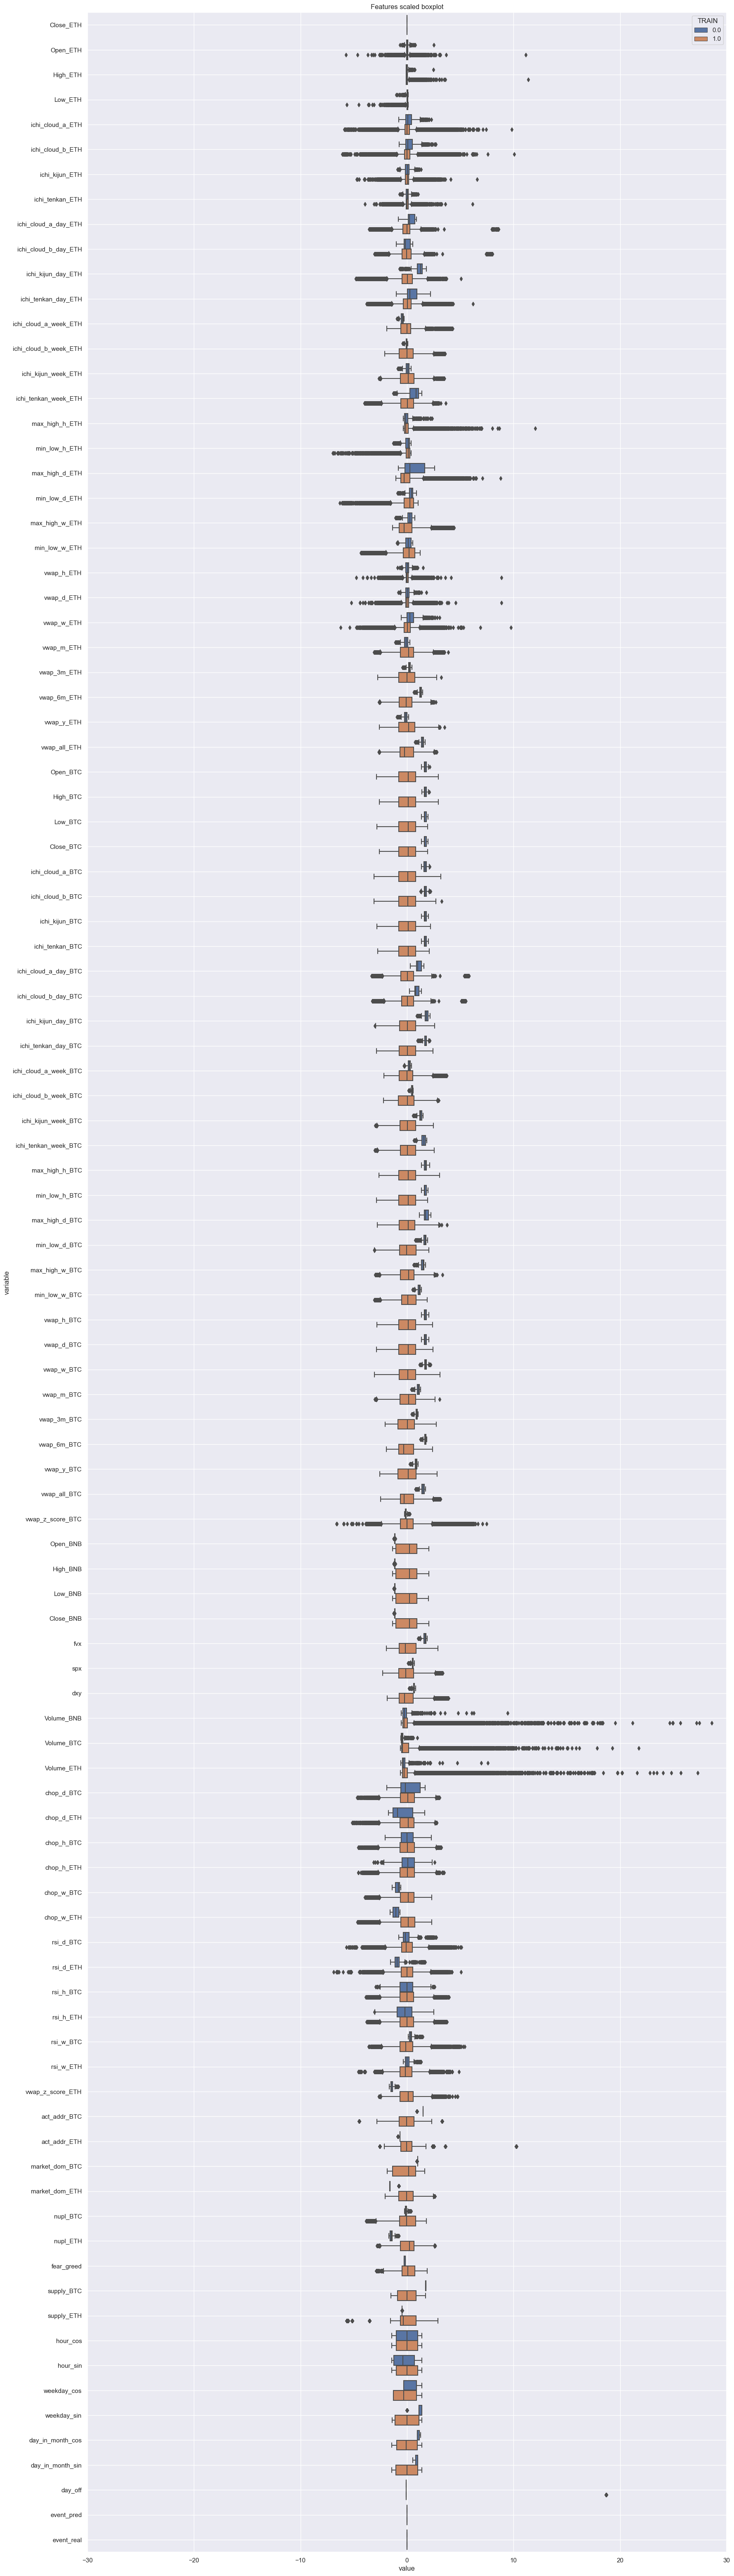

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

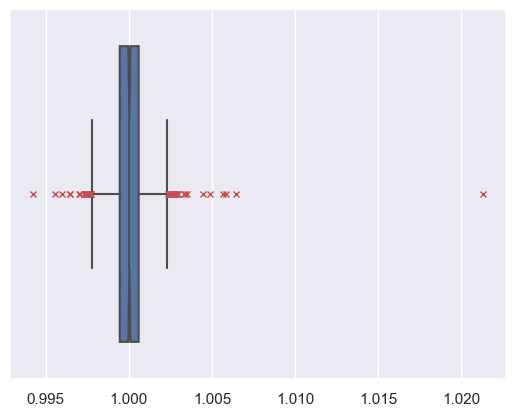

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


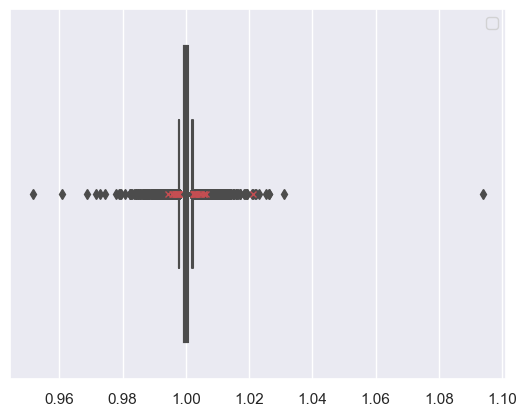

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

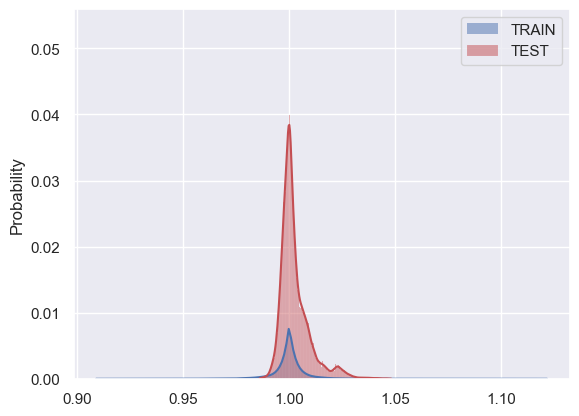

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(78891, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(78891, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10414024],
       [-0.03026879],
       [-0.20242662],
       ...,
       [-0.03458682],
       [-0.33927238],
       [ 0.04964143]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(78891, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

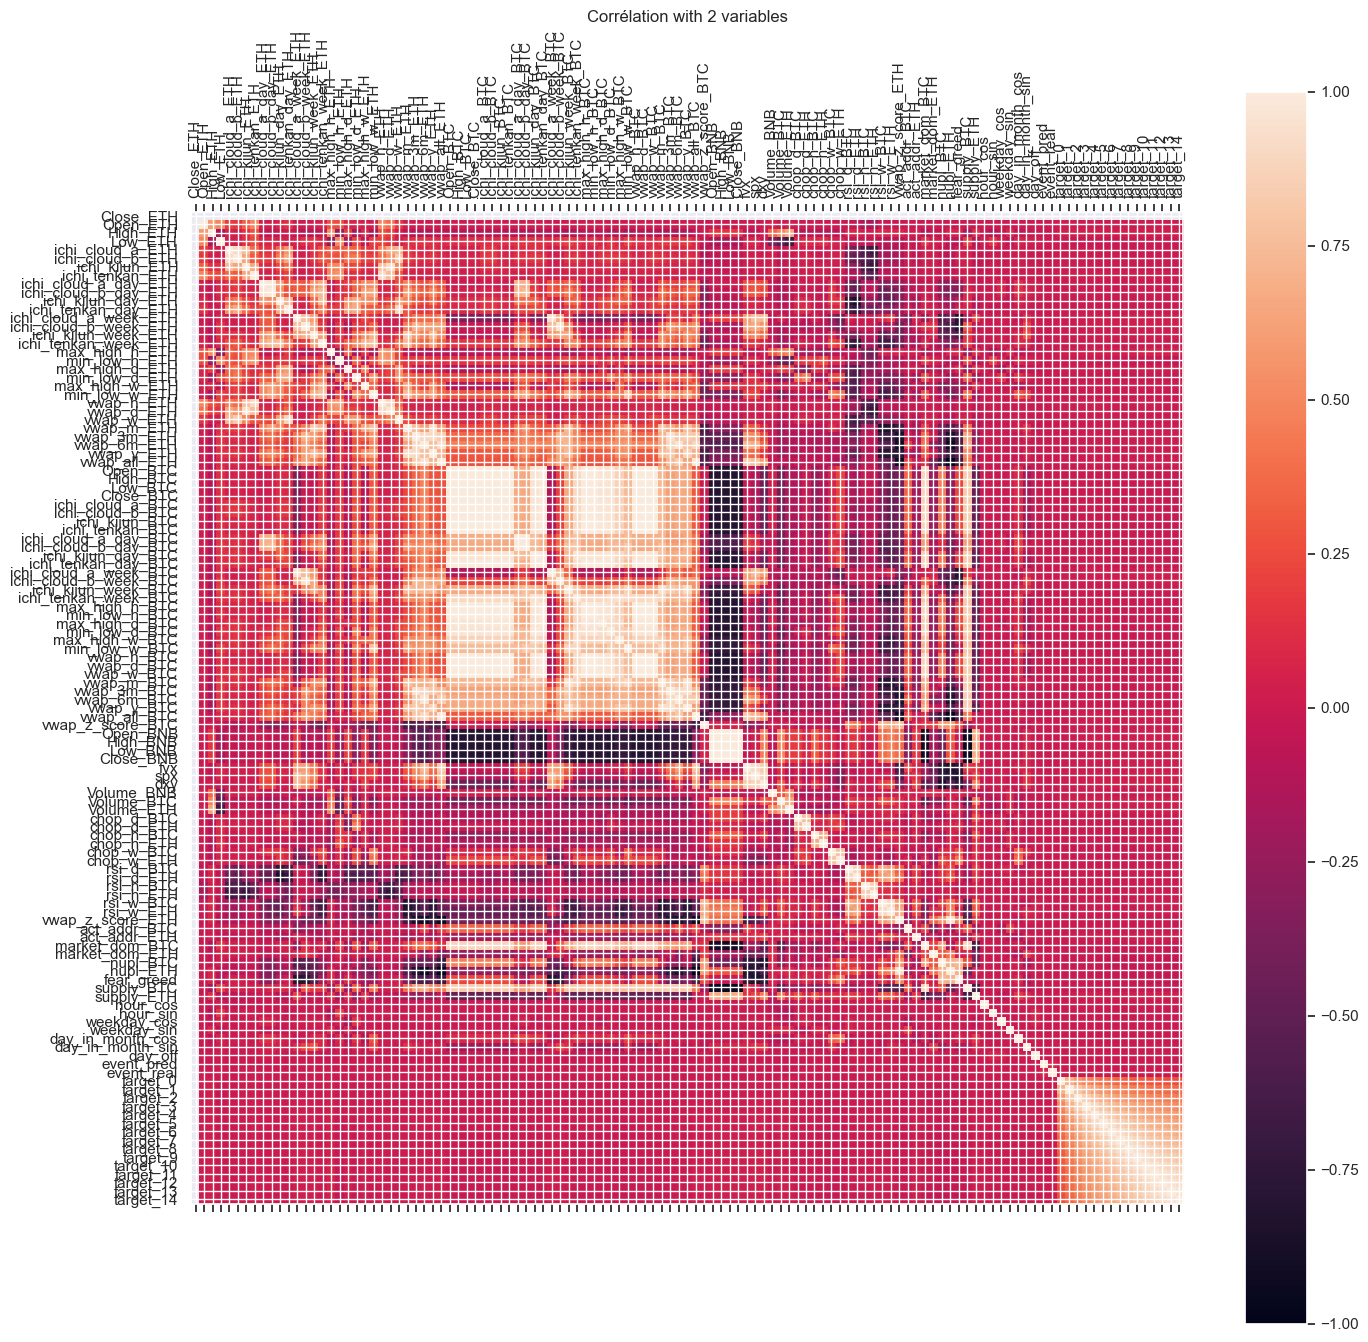

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


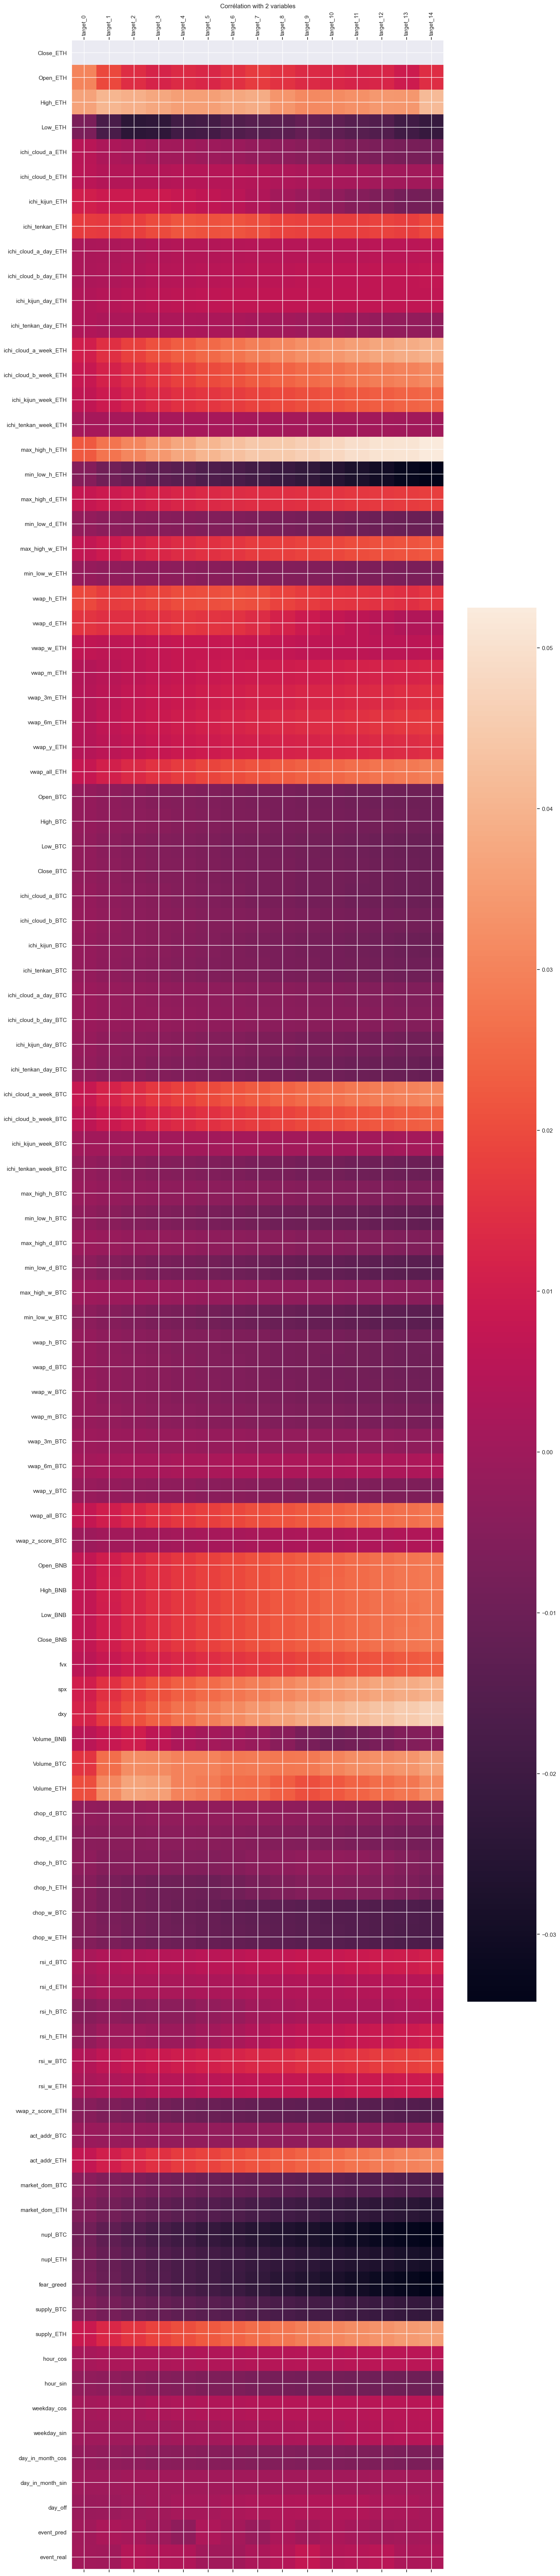

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


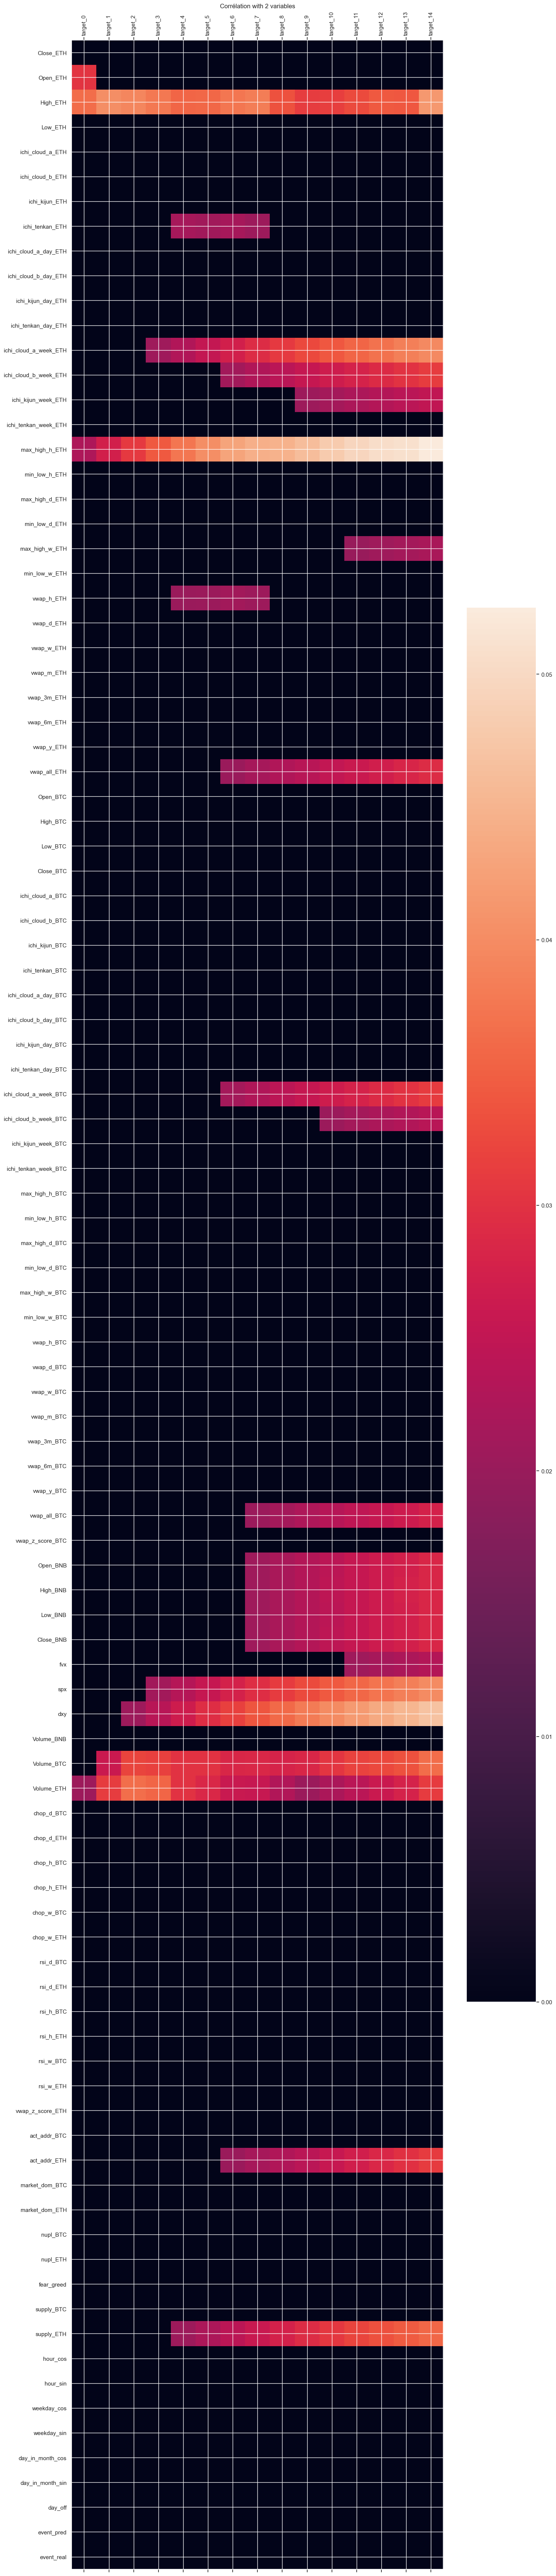

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

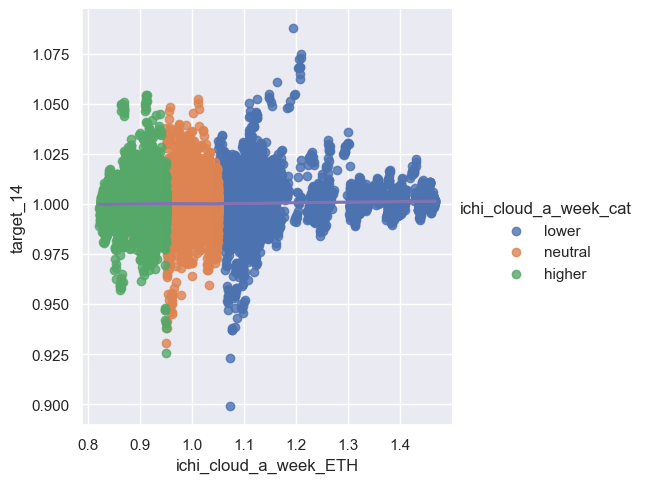

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

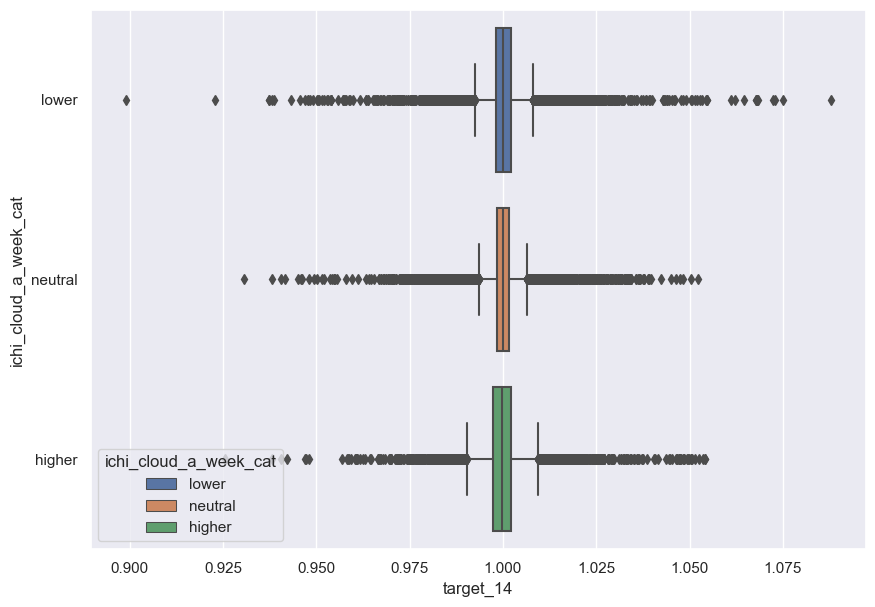

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


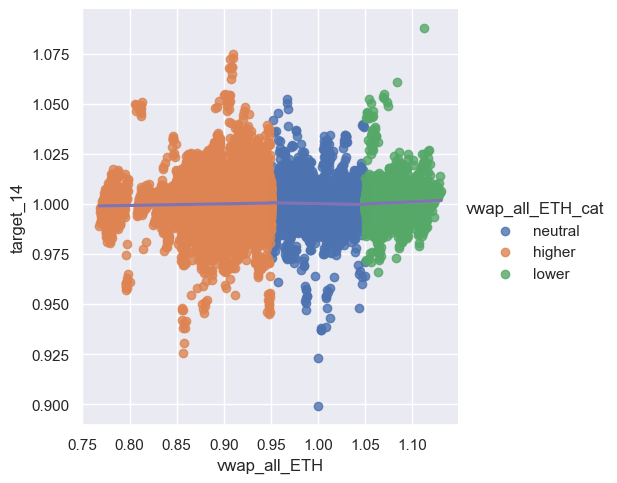

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

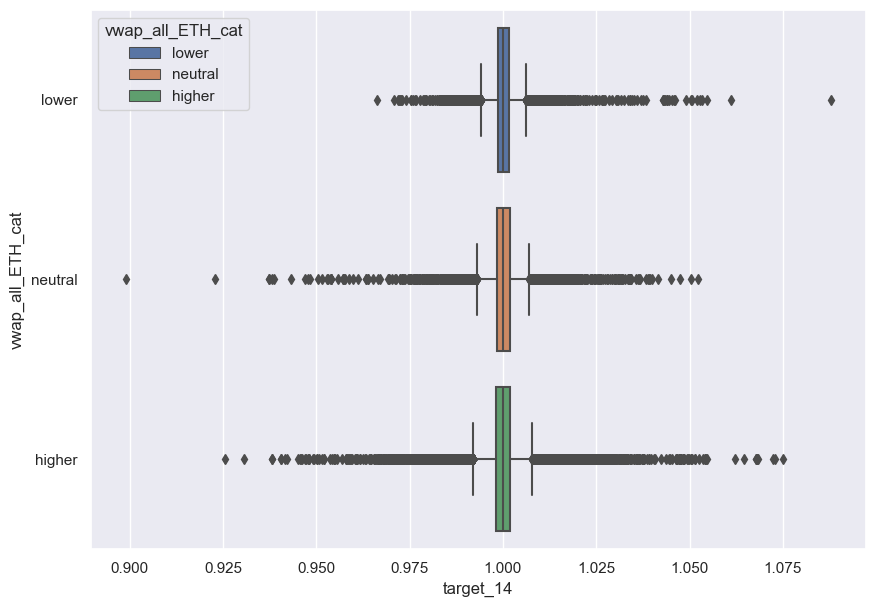

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

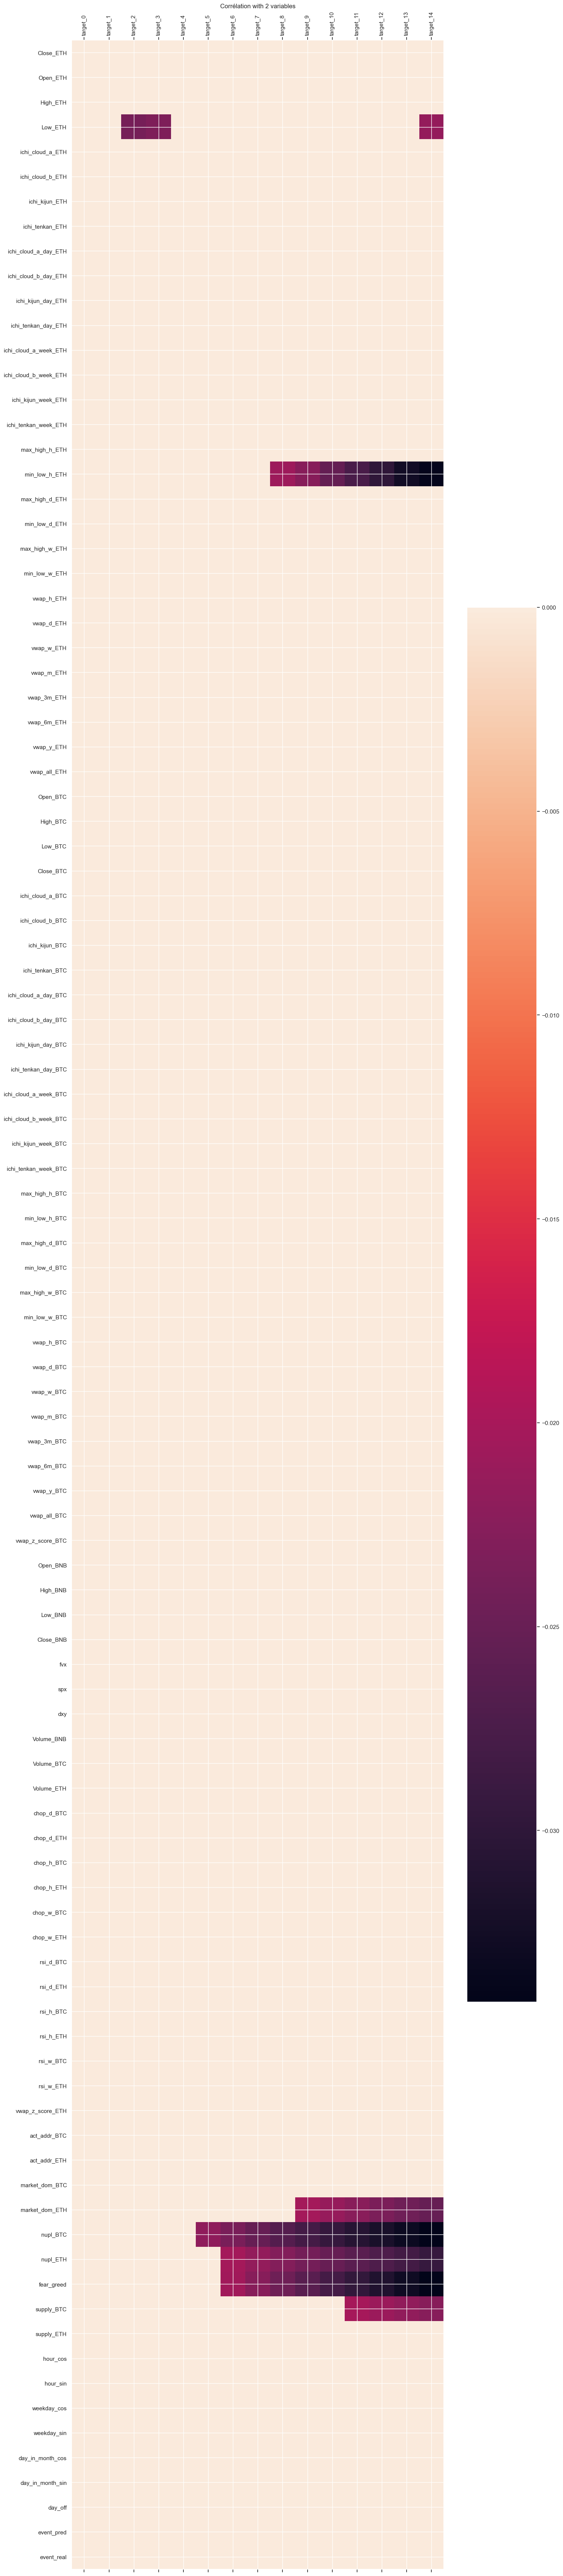

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

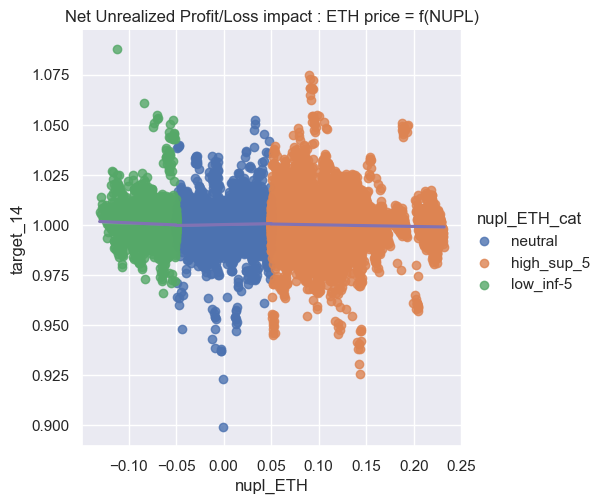

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

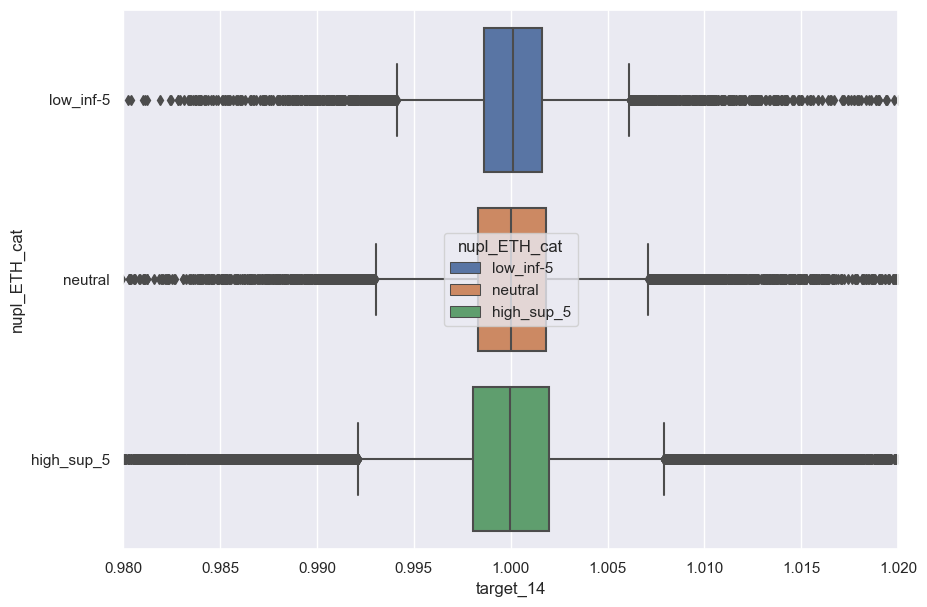

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    78891.000000
mean         1.000085
std          0.005434
min          0.899006
25%          0.998168
50%          1.000012
75%          1.001895
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    78891.000000
mean         1.000011
std          0.002016
min          0.907143
25%          0.999287
50%          1.000000
75%          1.000732
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

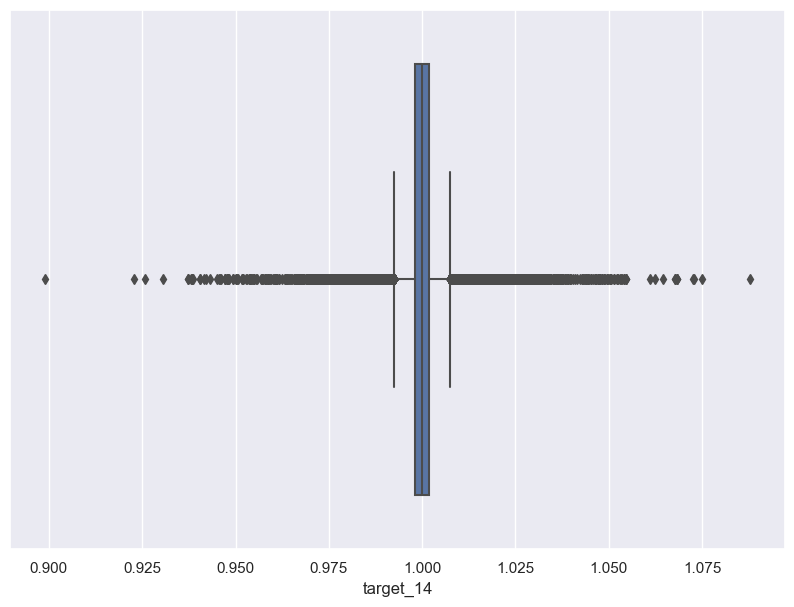

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99990748, 0.99860065, 0.99884351, ..., 0.99816696, 0.99786049,
        0.99804553],
       [0.99869304, 0.99893593, 0.99870461, ..., 0.99795282, 0.99813788,
        0.99893015],
       [1.0002432 , 1.00001158, 0.99972784, ..., 0.99944411, 1.00023741,
        1.00081068]])

In [89]:
y_train_sca

array([[ 0.10414024,  0.08523774, -0.10588745, ..., -0.03867859,
         0.02642999, -0.0470797 ],
       [-0.03026879, -0.22130602, -0.0533612 , ..., -0.08904947,
        -0.16252533, -0.31157637],
       [-0.20242662, -0.03446915, -0.15413884, ..., -0.1436415 ,
        -0.29270376, -0.36408569],
       ...,
       [-0.03458682, -0.36245386, -0.30152282, ..., -0.4712593 ,
        -0.54814847, -0.50172482],
       [-0.33927238, -0.27833569, -0.33637063, ..., -0.52498417,
        -0.47855622, -0.27978657],
       [ 0.04964143, -0.00846945, -0.07965528, ..., -0.15084111,
         0.04818866,  0.1920131 ]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(78891, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [128]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          120336    
                                                                 
 model_1 (Functional)        (None, None, 102)         87398     
                                                                 
Total params: 207734 (811.46 KB)
Trainable params: 207734 (811.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 

### Save model

In [95]:
# TODO select best model


In [96]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [97]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [98]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2466/2466 [==============================] - 55s 22ms/step


(78891, 72, 102)

### Results

In [99]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

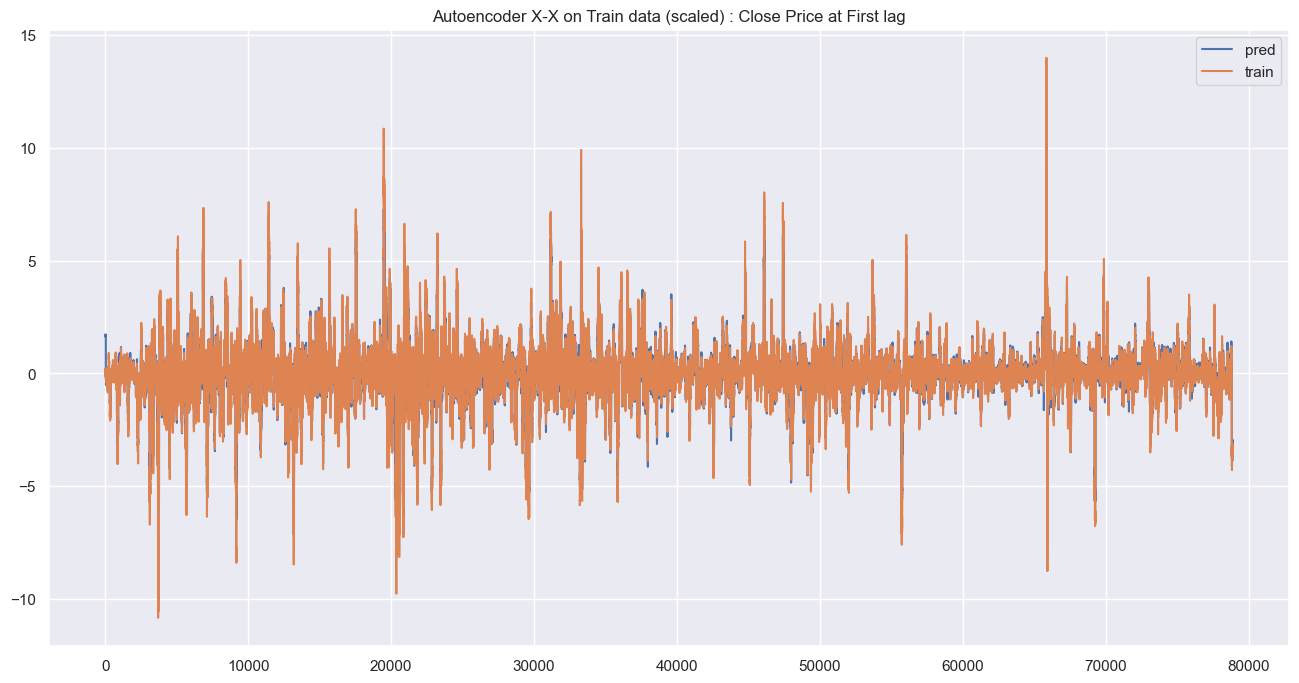

In [100]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [101]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(78891, 72, 102)
(78891, 72, 102)
(72, 102)
(1, 102)


In [102]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.129721  0.135715  0.124720  0.129317          0.255195   
lag_1    0.109532  0.107633  0.100228  0.104354          0.230124   
lag_2    0.097814  0.096536  0.086947  0.090746          0.210948   
lag_3    0.094037  0.091734  0.081767  0.086760          0.198978   
lag_4    0.092627  0.089833  0.079845  0.085294          0.189204   
...           ...       ...       ...       ...               ...   
lag_67   0.087059  0.087913  0.074269  0.082406          0.125350   
lag_68   0.086816  0.087820  0.074105  0.082231          0.125325   
lag_69   0.086589  0.087720  0.073912  0.082061          0.125307   
lag_70   0.086386  0.087598  0.073765  0.081872          0.125275   
lag_71   0.086125  0.087572  0.073581  0.081674          0.125255   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.283923        0.156160         0.149863   
lag_1           0.257615        0.132578         0.123091   
lag_2           0.238168        0.123171         0.110981   
lag_3           0.225810        0.117989         0.100792   
lag_4           0.215637        0.115354         0.094024   
...                  ...             ...              ...   
lag_67          0.143251        0.099760         0.078037   
lag_68          0.143225        0.099723         0.078007   
lag_69          0.143216        0.099685         0.077967   
lag_70          0.143210        0.099646         0.077924   
lag_71          0.143247        0.099599         0.077888   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.242710              0.208116  ...    0.243356  0.508451   
lag_1               0.191168              0.163732  ...    0.188995  0.333577   
lag_2               0.167384              0.140553  ...    0.163992  0.280989   
lag_3               0.153977              0.126693  ...    0.146363  0.248887   
lag_4               0.145562              0.117497  ...    0.134601  0.226927   
...                      ...                   ...  ...         ...       ...   
lag_67              0.108832              0.090320  ...    0.081440  0.141674   
lag_68              0.108844              0.090298  ...    0.081438  0.141632   
lag_69              0.108863              0.090292  ...    0.081438  0.141584   
lag_70              0.108882              0.090272  ...    0.081436  0.141521   
lag_71              0.108898              0.090258  ...    0.081439  0.141491   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.515973     0.465330     0.449555          0.529025   
lag_1   0.358357     0.301426     0.295179          0.382991   
lag_2   0.307685     0.249687     0.248985          0.316744   
lag_3   0.276454     0.219856     0.221180          0.269515   
lag_4   0.254032     0.201016     0.202385          0.236195   
...          ...          ...          ...               ...   
lag_67  0.156267     0.137377     0.132881          0.121052   
lag_68  0.156242     0.137354     0.132842          0.121068   
lag_69  0.156215     0.137346     0.132785          0.121093   
lag_70  0.156221     0.137333     0.132714          0.121121   
lag_71  0.156204     0.137315     0.132641          0.121158   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.520154  0.280044    0.693478    0.301584  
lag_1           0.363888  0.184730    0.354203    0.164837  
lag_2           0.289875  0.108811    0.181924    0.094092  
lag_3           0.249487  0.080601    0.115145    0.064835  
lag_4           0.219861  0.070366    0.096095    0.056158  
...                  ...       ...         ...         ...  
lag_67          0.115245  0.048476    0.067014    0.045358  
lag_68          0.115212  0.048423    0.066960    0.045314  
lag_69          0.115188  0.048371    0.066921    0.045271  
lag_70          0.115168  0.048328    0.066880    0.045219  
lag_71          0.115151  0.04828

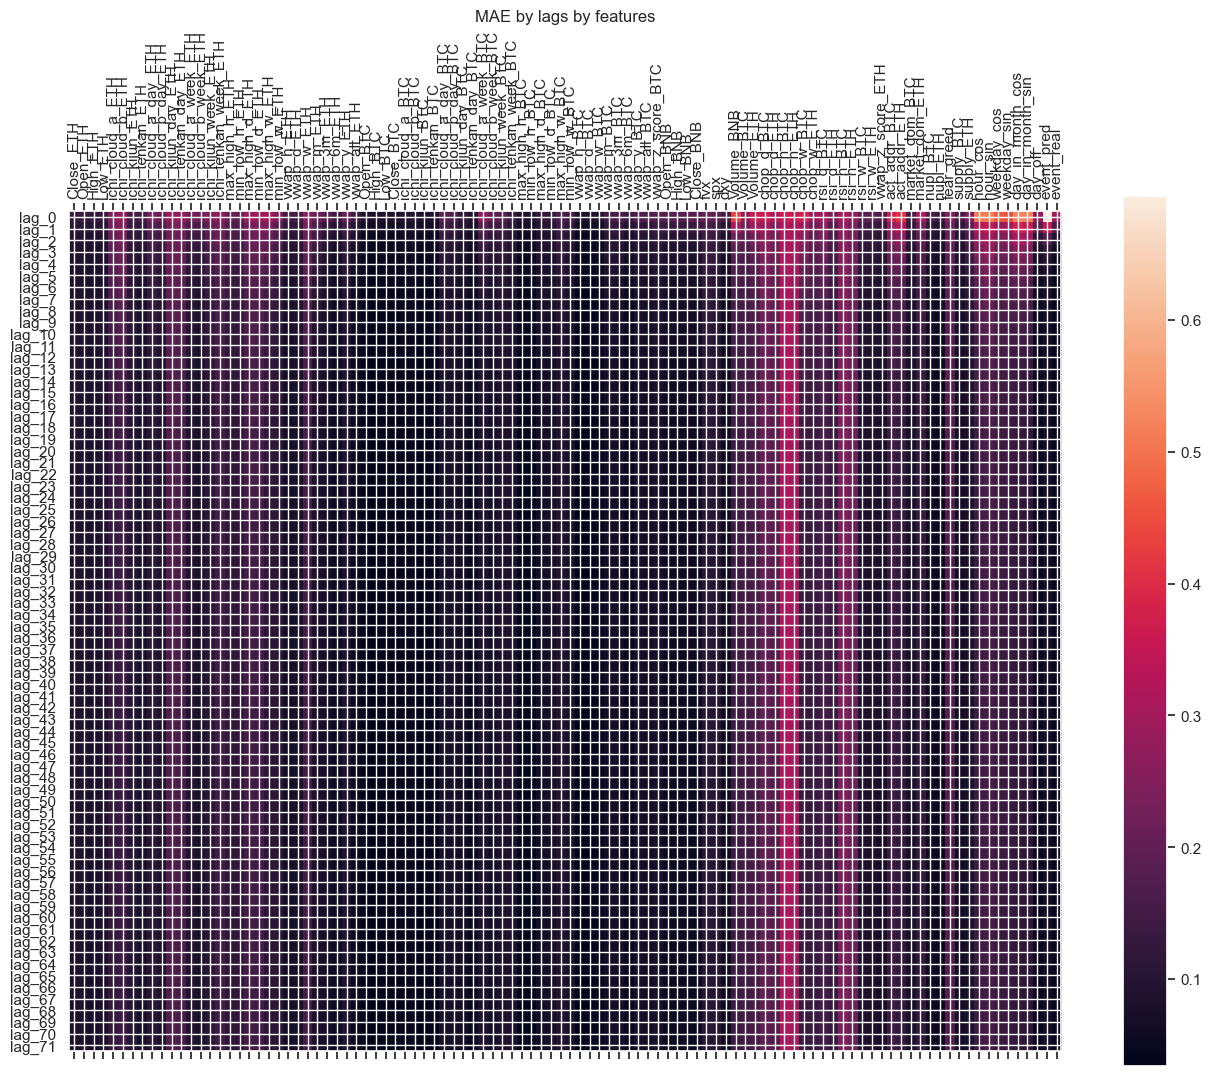

In [103]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

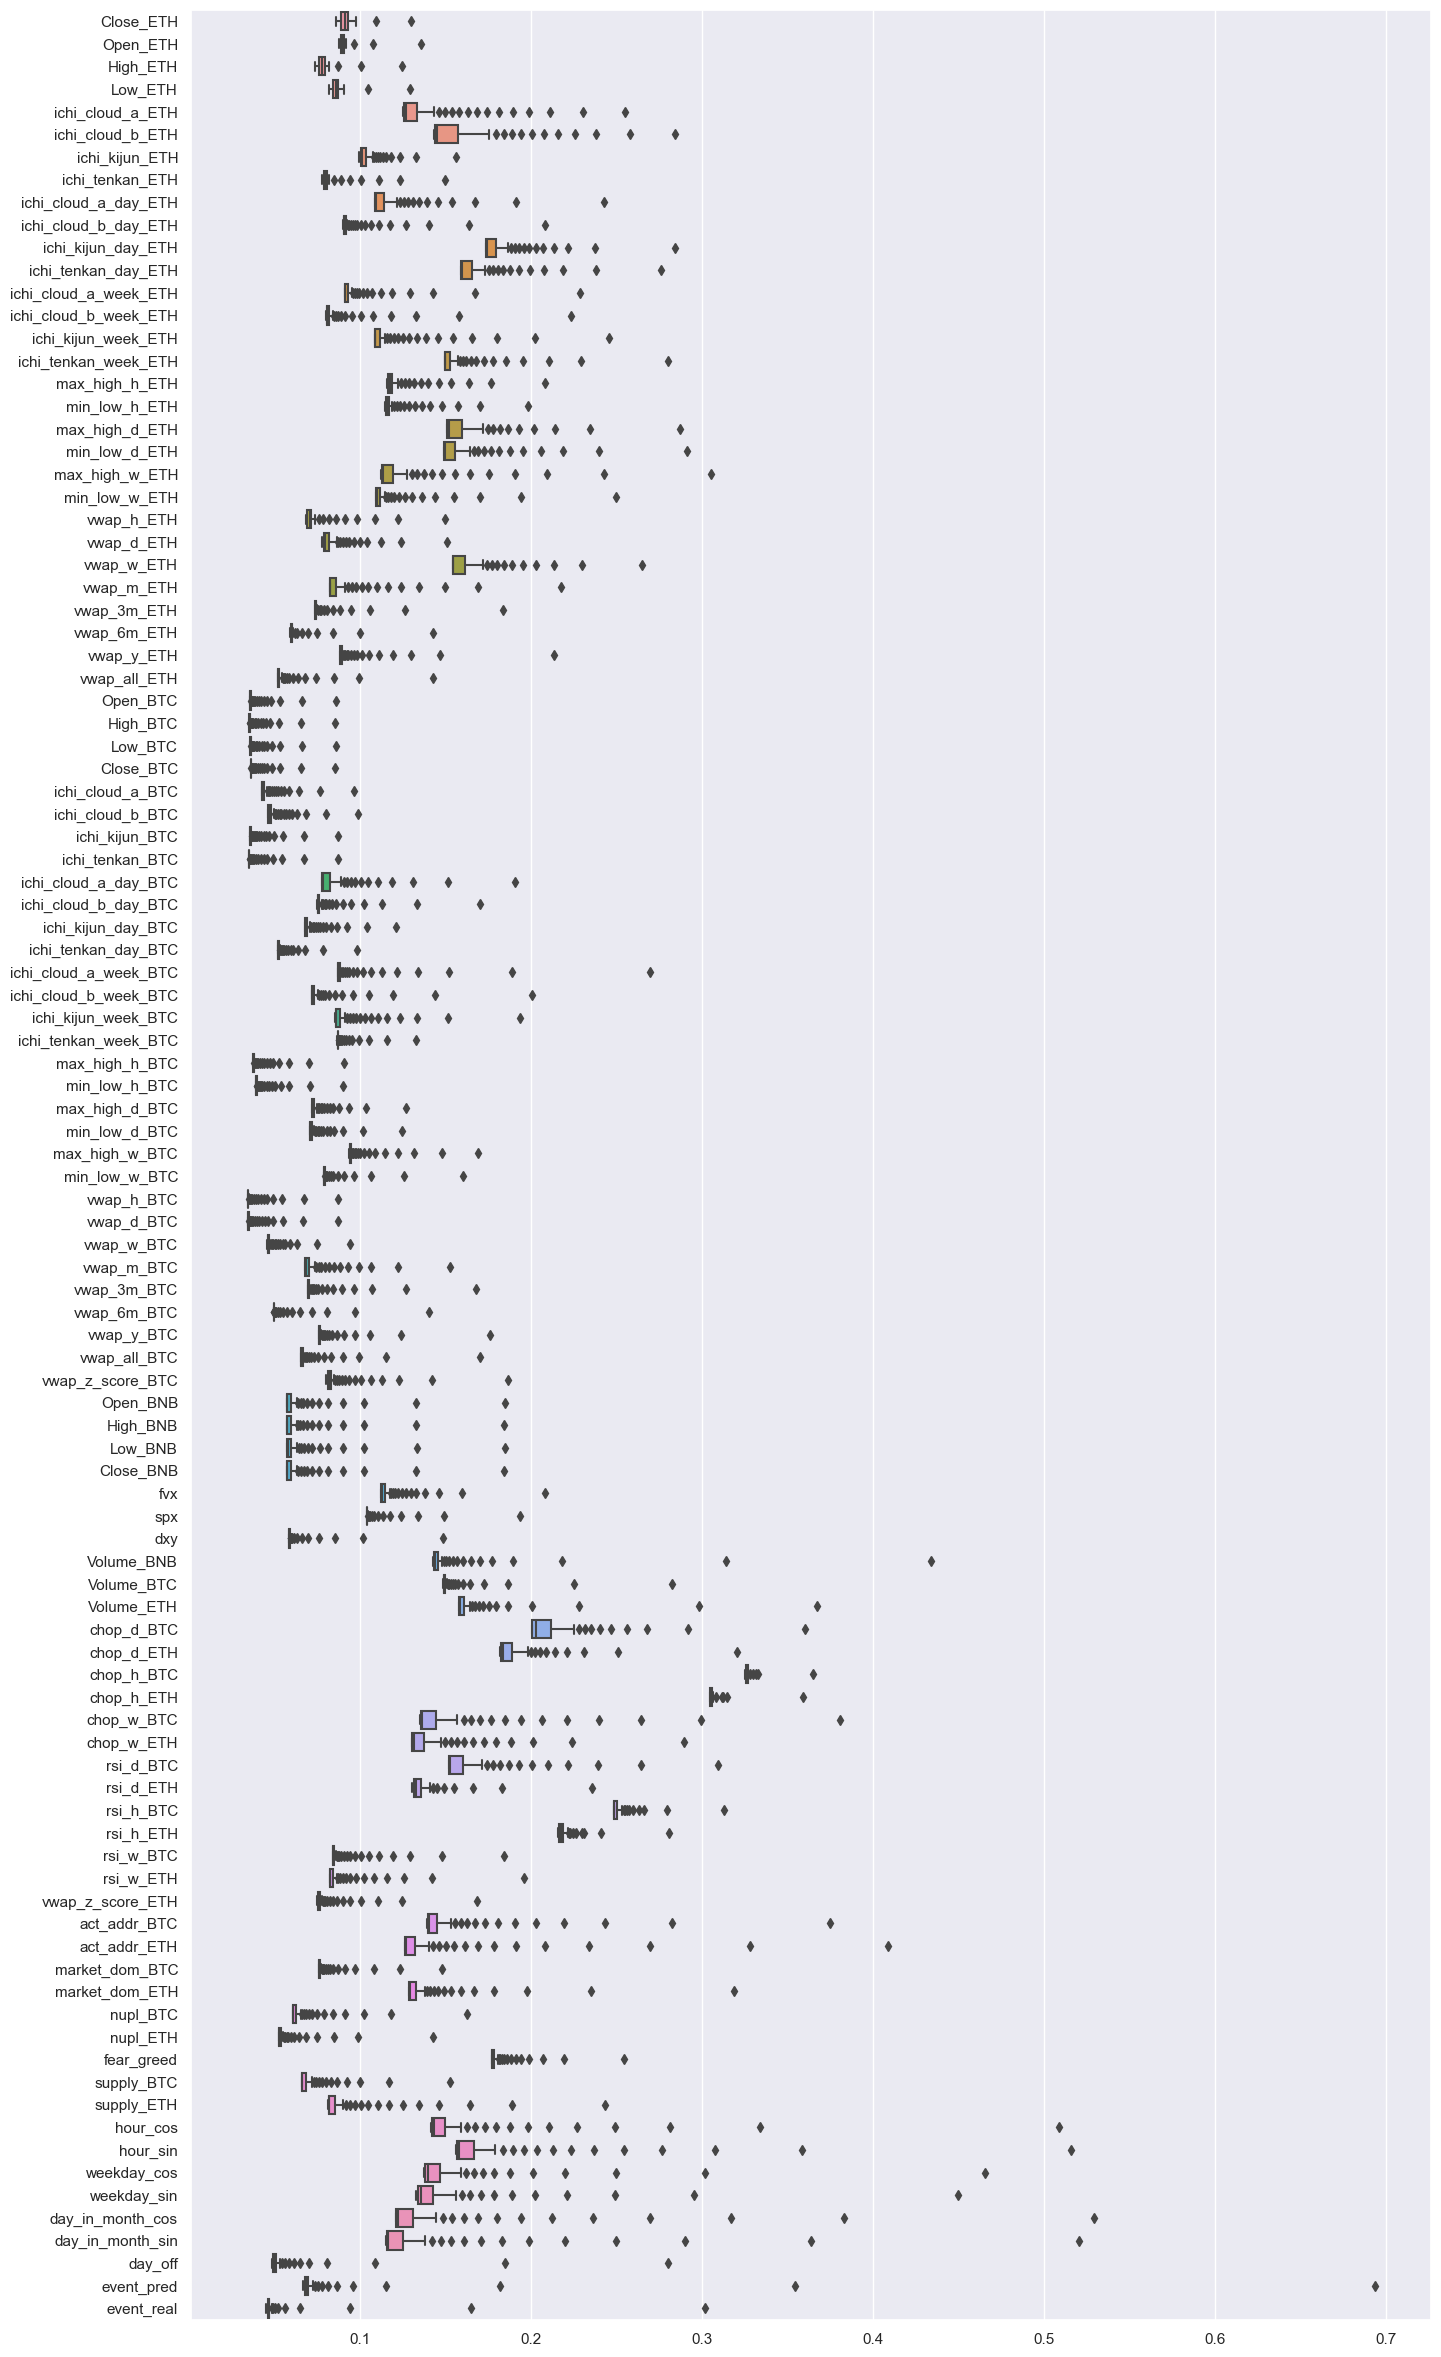

In [104]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [105]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0   0.091771  0.090637  0.078449  0.08625          0.137626          0.158173   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        0.103932         0.082341              0.116959   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.096156  ...    0.091495  0.160227  0.176697      0.15348   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0     0.149681          0.144399          0.137412  0.05714    0.084322   

   event_real  
0    0.052788  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

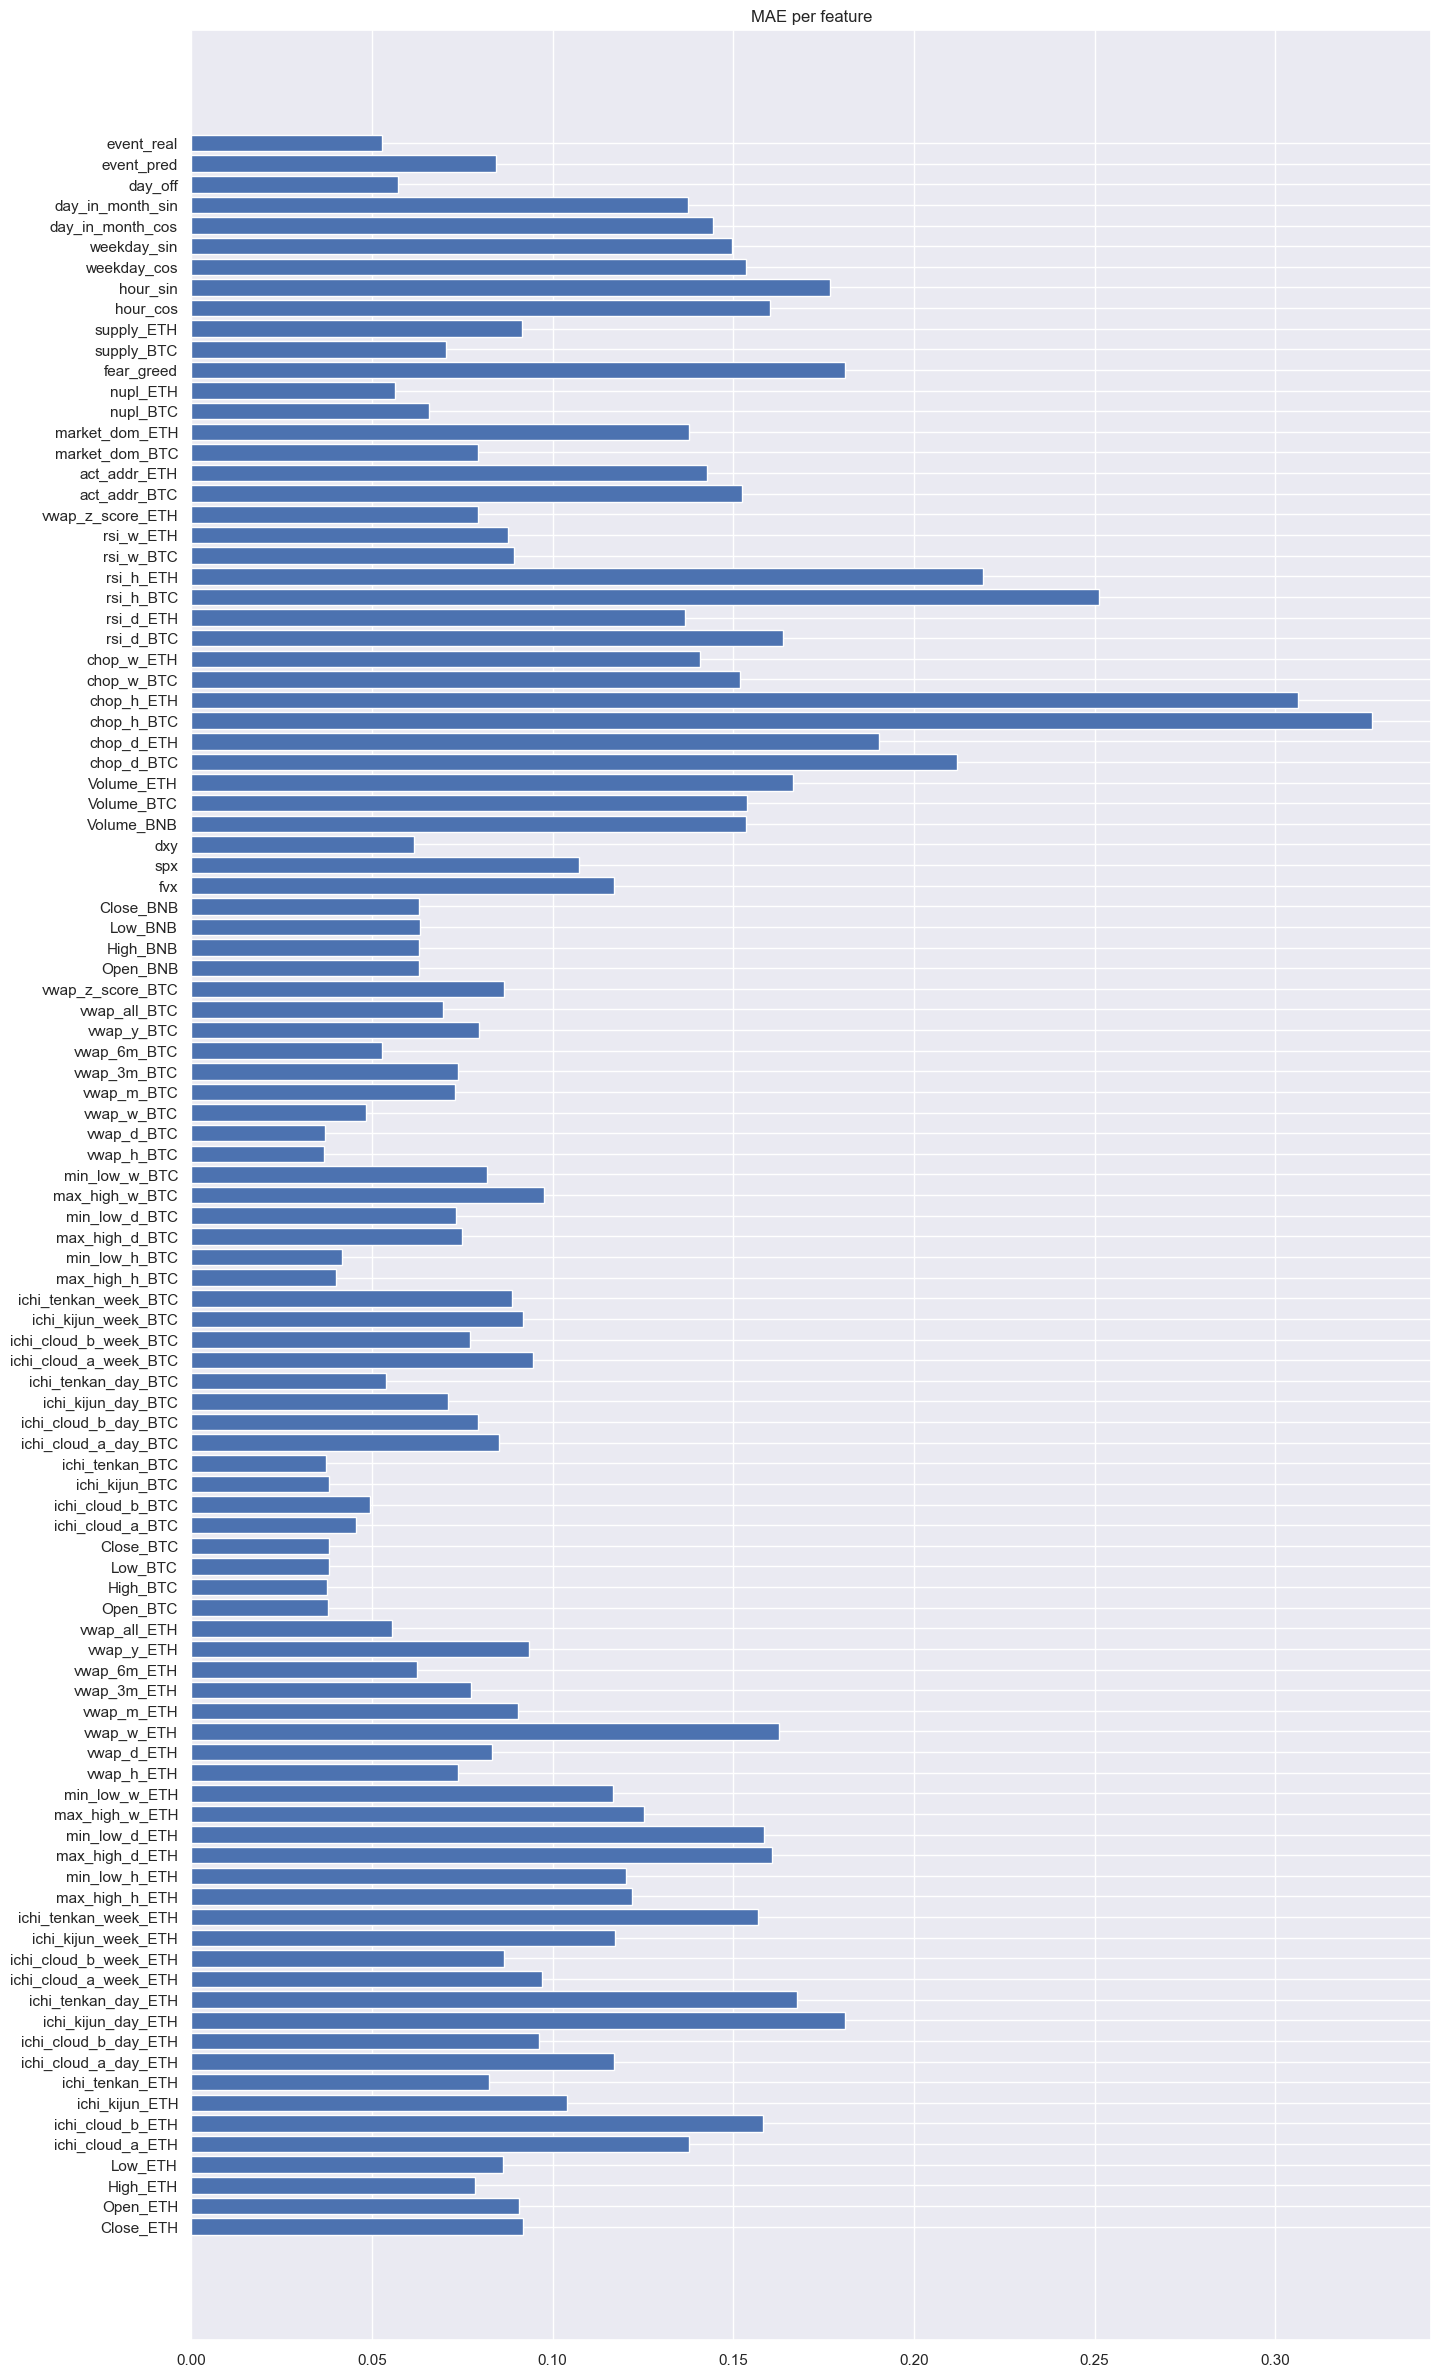

In [106]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [107]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(78891,)
(78891,)
[1196.32 1195.38 1194.55 ... 1677.25 1677.86 1680.19]
[1196.32 1195.38 1194.55]


In [108]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9984924 , 0.99928033, 0.9996914 , ..., 1.0000352 , 1.0003198 ,
       1.0010848 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1677.25 1677.86 1680.19]
[1211.37242329 1211.81534596 1211.95201457 ... 1682.21901498 1679.94912402
 1683.95951412]


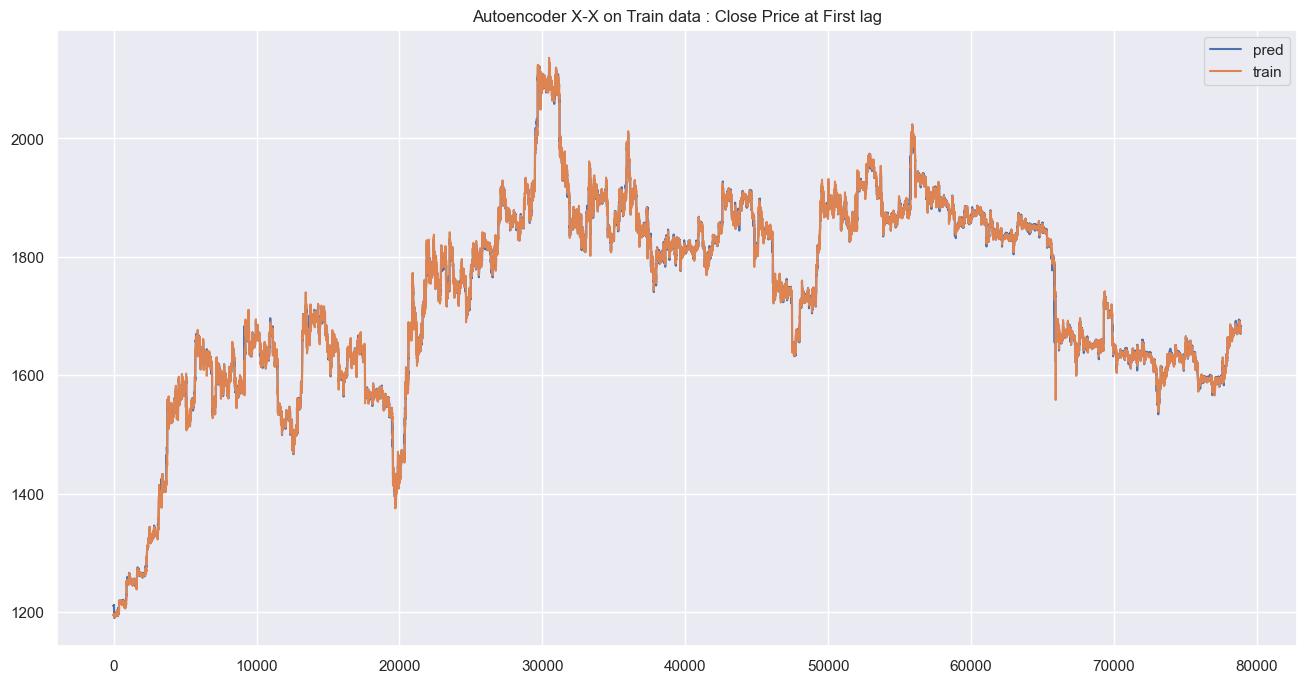

In [109]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [110]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

23/23 [==============================] - 1s 35ms/step


(710, 72, 102)

In [111]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-10-02 05:25:00'

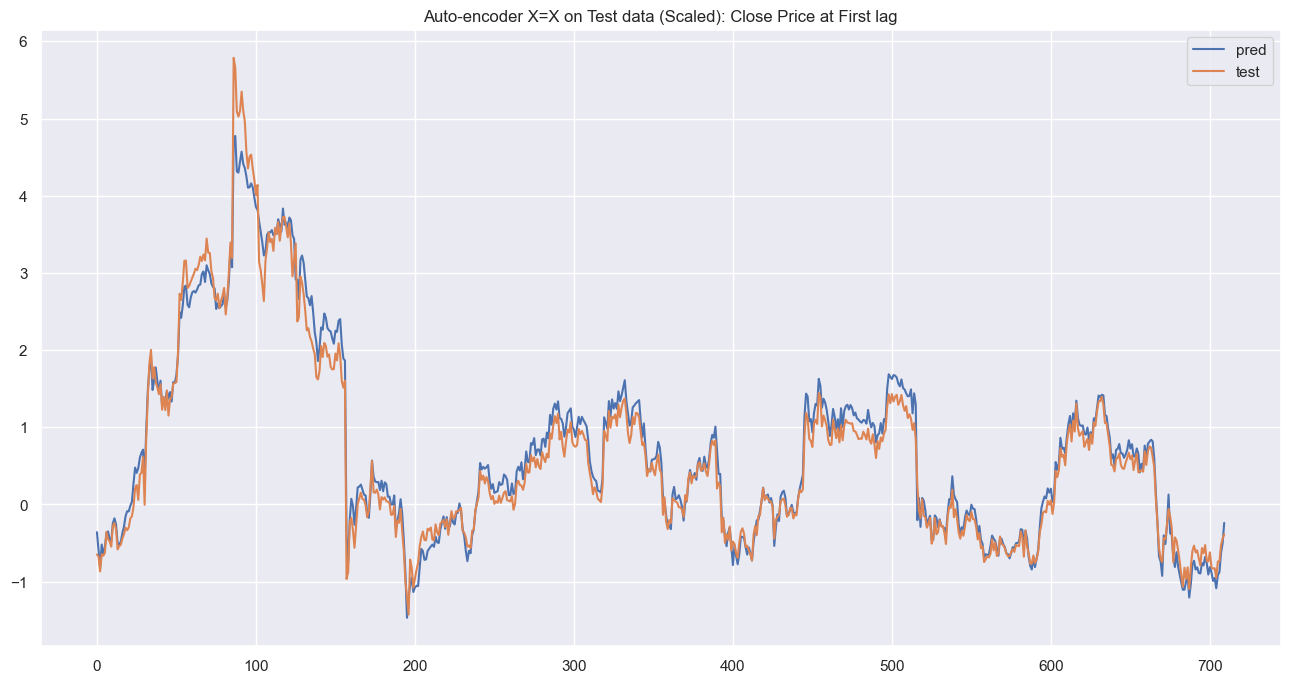

In [112]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [113]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1723.28 1721.83 1717.65 1716.63 1717.43 1718.   1719.74 1719.17 1720.06]
X test pred :  [1727.44582471 1722.93879377 1718.30547983 1718.44011752 1717.82541069
 1719.05260926 1719.57405141 1720.61170381 1720.46419046]


[1723.28 1721.83 1717.65 1716.63 1717.43 1718.   1719.74 1719.17 1720.06
 1719.49 1722.31 1723.4  1723.34 1723.66 1723.51 1723.35 1724.22 1724.91
 1725.2  1723.64 1723.17 1724.88 1726.34 1725.66 1727.19 1730.41 1729.11
 1731.6  1729.74 1730.42 1727.72 1729.93 1731.72 1733.64 1733.19 1734.96
 1736.78 1738.77 1736.48 1736.   1735.16 1734.24 1735.71 1733.27 1733.4
 1730.41 1730.52 1734.26 1734.37 1733.55 1731.49 1732.32 1731.94 1731.54
 1731.92 1731.73 1731.56 1731.2  1732.31 1732.41 1731.7  1730.81 1731.79
 1731.72 1731.51 1731.47 1731.   1729.21 1729.5  1732.37 1733.07 1732.86
 1731.8  1730.39 1726.14 1727.21 1727.26 1725.07 1725.87 1727.18 1727.59
 1726.53 1727.09 1728.19 1732.28 1731.55 1731.1  1730.85 1730.71 1729.74
 1728.68 1727.69 1727.72 1728.77 1726.33 1724.39 1727.03 1728.48 1726.25
 1724.05 1721.83 1728.01 1717.99 1712.01 1707.78 1704.92 1711.87 1711.62
 1716.31 1715.02 1715.79 1713.13 1716.89 1715.98 1716.   1712.56 1714.17
 1711.27 1714.6  1712.24 1711.23 1709.13 1704.53 169

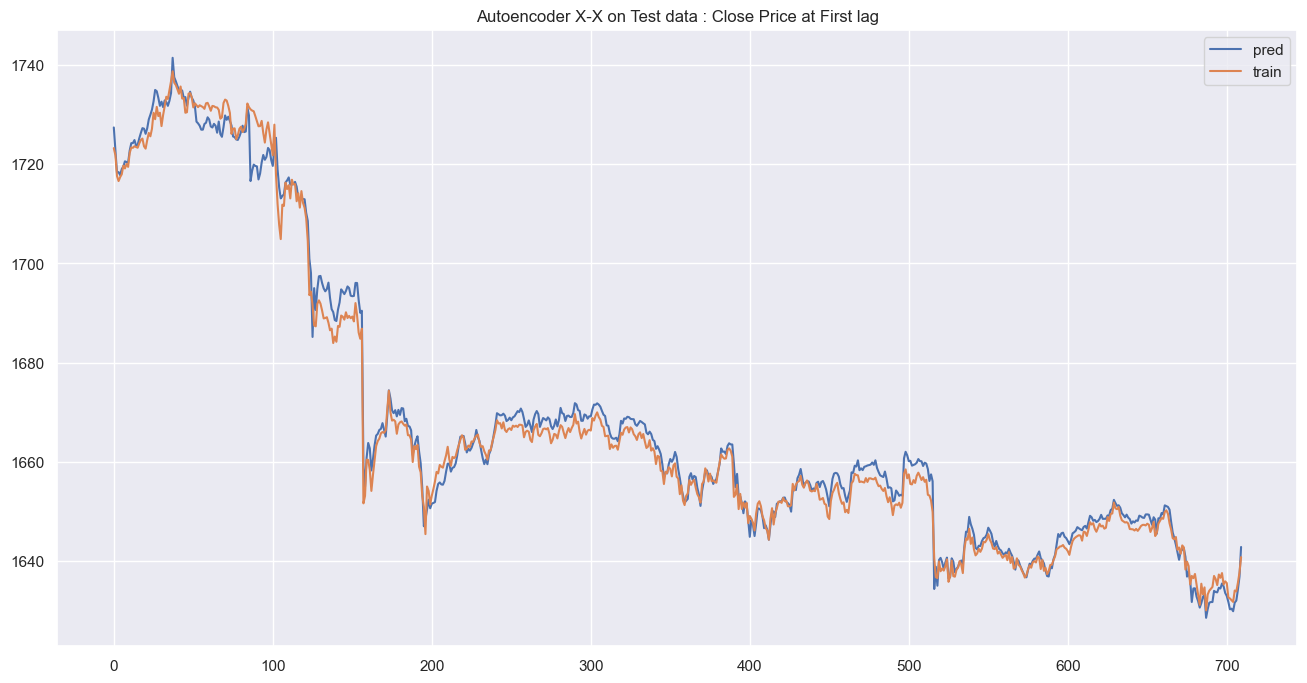

In [114]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [115]:
X_test_sca.shape

(710, 72, 102)

In [116]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.28241699483774135

In [117]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(710, 72, 102)
(710, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.129721  0.135715  0.124720  0.129317          0.255195   
lag_1    0.109532  0.107633  0.100228  0.104354          0.230124   
lag_2    0.097814  0.096536  0.086947  0.090746          0.210948   
lag_3    0.094037  0.091734  0.081767  0.086760          0.198978   
lag_4    0.092627  0.089833  0.079845  0.085294          0.189204   
...           ...       ...       ...       ...               ...   
lag_67   0.088714  0.088603  0.078120  0.085013          0.146668   
lag_68   0.088547  0.088589  0.078117  0.084936          0.146051   
lag_69   0.088620  0.088521  0.077968  0.084819          0.145590   
lag_70   0.088520  0.088181  0.077788  0.084490          0.145005   
lag_71   0.088483  0.088228  0.077830  0.084703          0.144519   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.283923        0.156160         0.149863   
lag_1           0.257615        0.132578         0.123091   
lag_2           0.238168        0.123171         0.110981   
lag_3           0.225810        0.117989         0.100792   
lag_4           0.215637        0.115354         0.094024   
...                  ...             ...              ...   
lag_67          0.193943        0.099178         0.080640   
lag_68          0.193815        0.098847         0.080412   
lag_69          0.193772        0.098672         0.080175   
lag_70          0.193755        0.098514         0.079826   
lag_71          0.193665        0.098513         0.079626   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.242710              0.208116  ...  0.508451  0.515973   
lag_1               0.191168              0.163732  ...  0.333577  0.358357   
lag_2               0.167384              0.140553  ...  0.280989  0.307685   
lag_3               0.153977              0.126693  ...  0.248887  0.276454   
lag_4               0.145562              0.117497  ...  0.226927  0.254032   
...                      ...                   ...  ...       ...       ...   
lag_67              0.183015              0.185426  ...  0.237512  0.176174   
lag_68              0.183643              0.185019  ...  0.237423  0.176866   
lag_69              0.184202              0.184780  ...  0.237343  0.177451   
lag_70              0.184686              0.184495  ...  0.237423  0.178134   
lag_71              0.185239              0.184332  ...  0.237252  0.178740   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.465330     0.449555          0.529025          0.520154   
lag_1      0.301426     0.295179          0.382991          0.363888   
lag_2      0.249687     0.248985          0.316744          0.289875   
lag_3      0.219856     0.221180          0.269515          0.249487   
lag_4      0.201016     0.202385          0.236195          0.219861   
...             ...          ...               ...               ...   
lag_67     0.374416     0.143418          0.692112          0.921396   
lag_68     0.374723     0.144261          0.689739          0.920610   
lag_69     0.374922     0.145024          0.687563          0.919940   
lag_70     0.375128     0.145729          0.685723          0.919550   
lag_71     0.375200     0.146412          0.684013          0.919307   

         day_off  event_pred  event_real  dataset  
lag_0   0.280044    0.693478    0.301584    TRAIN  
lag_1   0.184730    0.354203    0.164837    TRAIN  
lag_2   0.108811    0.181924    0.094092    TRAIN  
lag_3   0.080601    0.115145    0.064835    TRAIN  
lag_4   0.070366    0.096095    0.056158    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.071922    0.095489    0.031990     TEST  
lag_68  0.071745    0.095311    0.031873     TEST  
lag_69  0.071607    0.095060    0.031692     TEST  
lag_70  0.071368    0.094695    0.031606     TEST  
lag_71  0.071241    0.094375    0.031483     TEST  

[144 ro

In [118]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.090849  0.092719  0.079191  0.088997          0.151574   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.205027        0.104041         0.085224              0.157881   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.253979  ...     0.16578  0.224108  0.196966     0.329963   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.120266           0.97255          1.130226  0.064447    0.107476   

   event_real  
0    0.041898  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

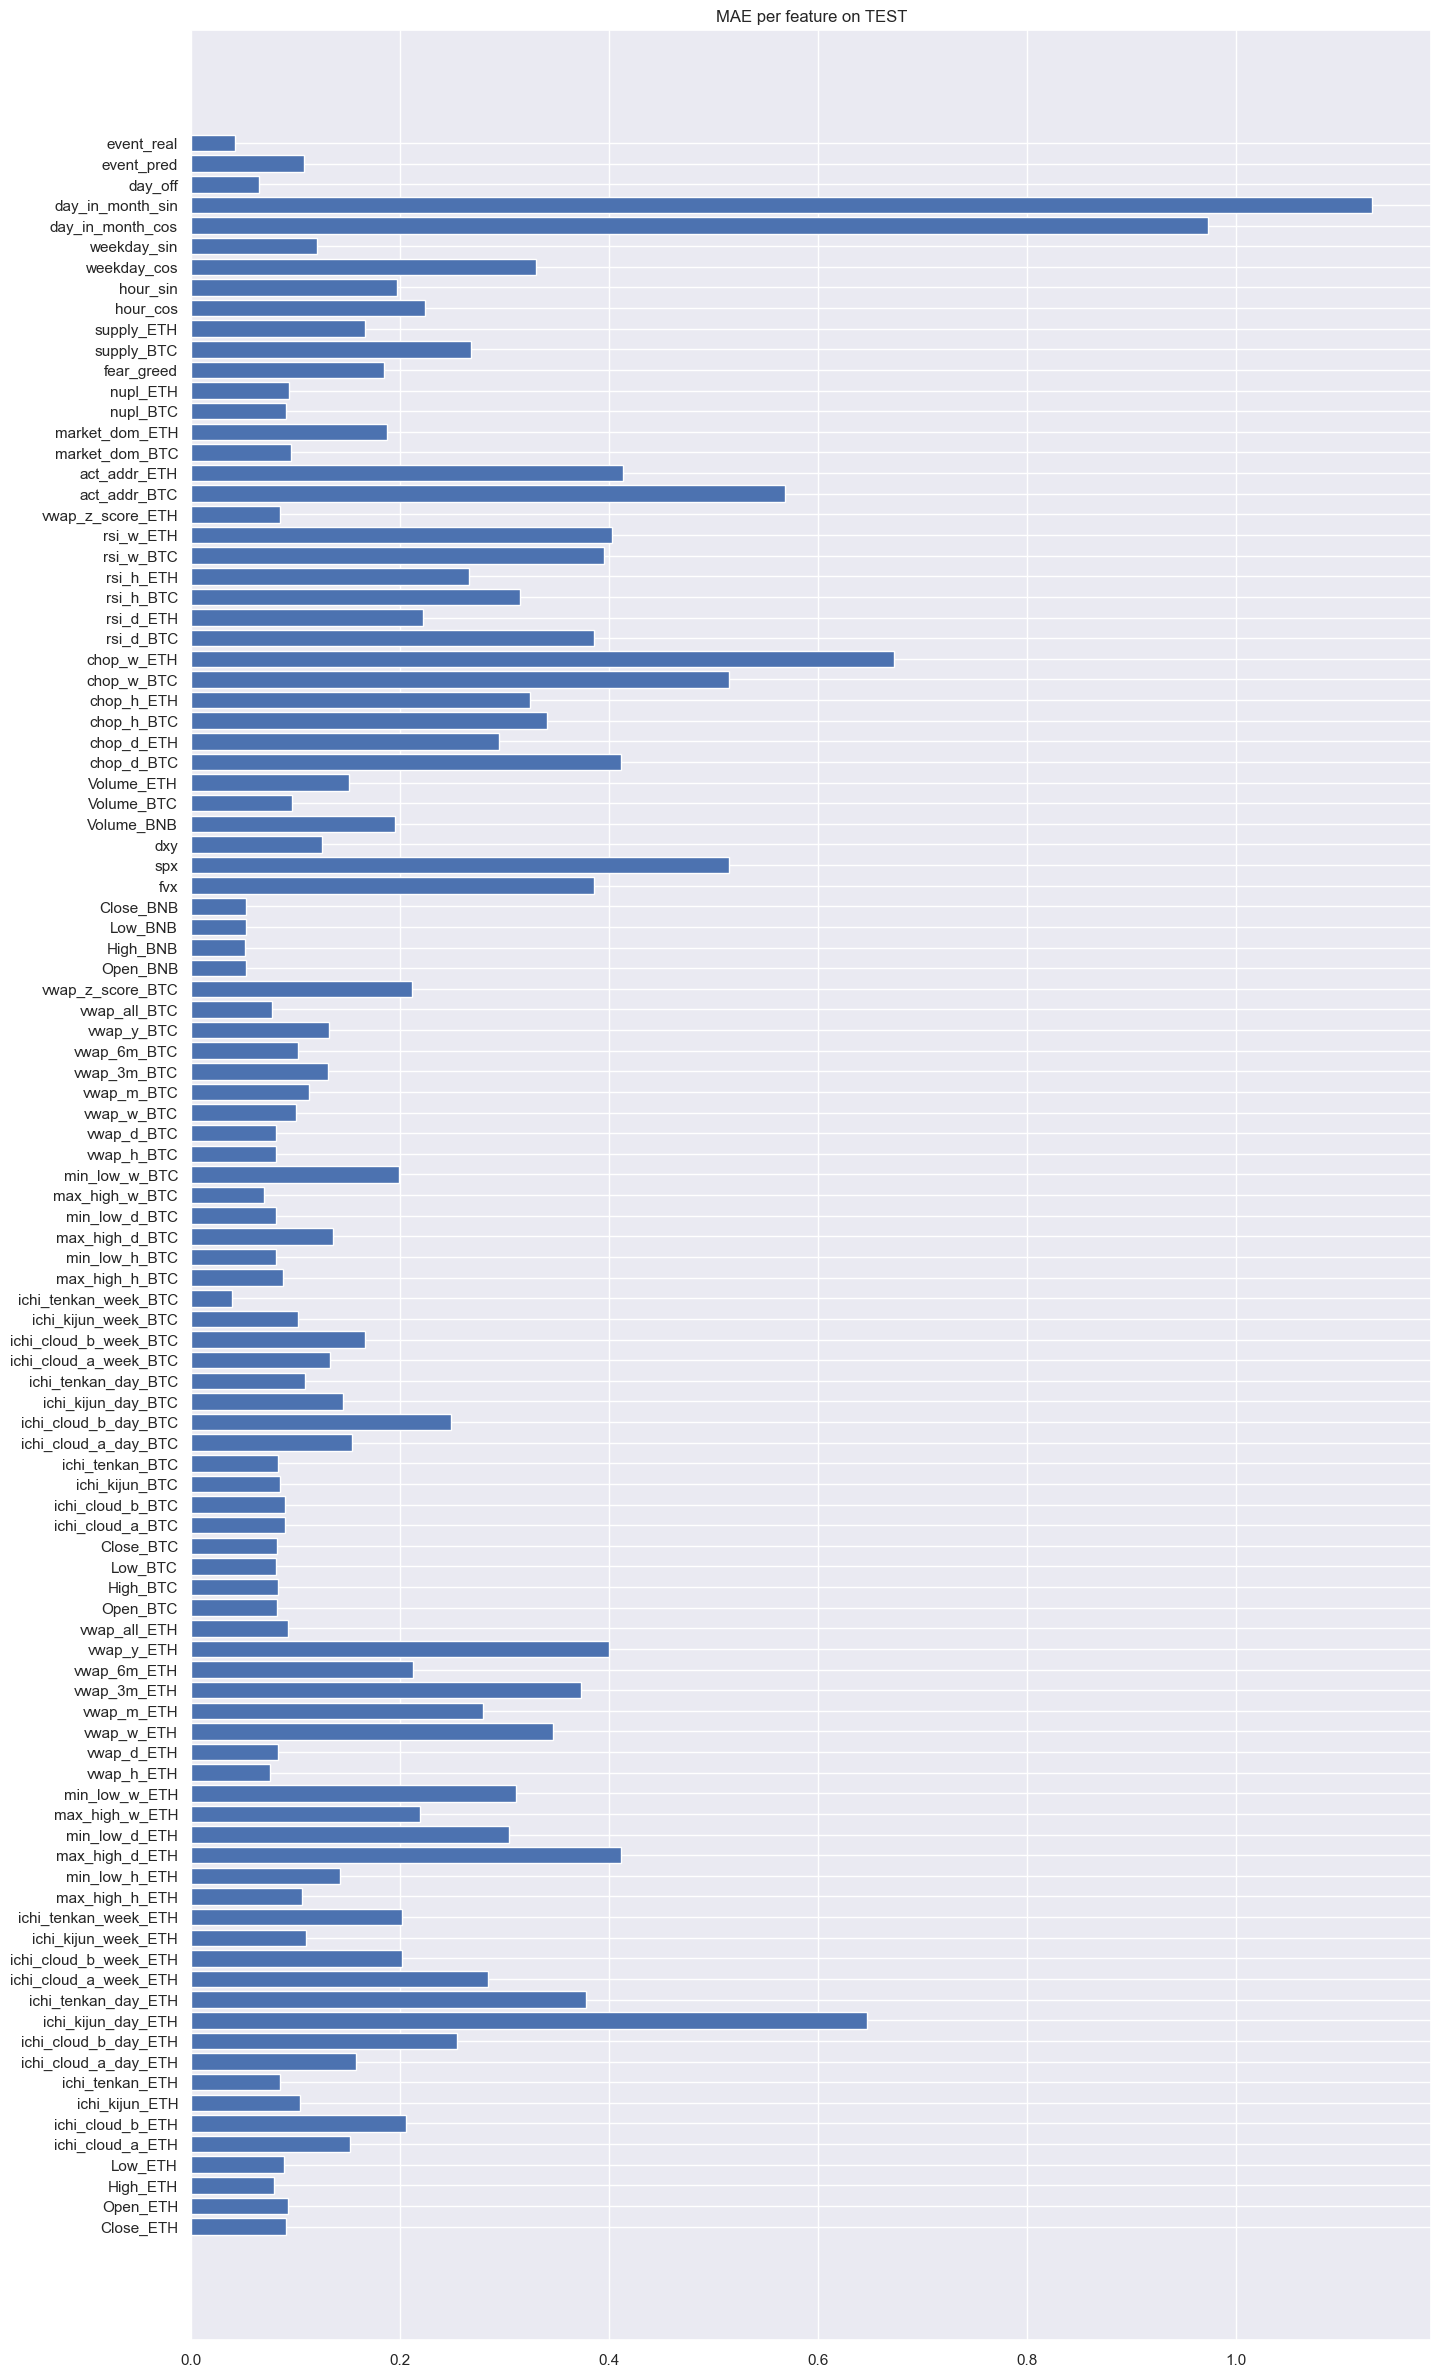

In [119]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [120]:
df_mae_ae_test_feat.values[0]

array([0.09084915, 0.09271946, 0.07919061, 0.08899721, 0.15157432,
       0.20502716, 0.10404144, 0.0852238 , 0.15788059, 0.25397855,
       0.64679108, 0.37780161, 0.28401195, 0.20151411, 0.11017433,
       0.20195186, 0.10600985, 0.14189024, 0.41142486, 0.30382376,
       0.21913085, 0.31114564, 0.07524274, 0.08311731, 0.34581013,
       0.2793289 , 0.3732479 , 0.21231052, 0.39940928, 0.09296931,
       0.08166216, 0.08265254, 0.08089133, 0.08186129, 0.0895244 ,
       0.0898135 , 0.08451108, 0.08257118, 0.15393419, 0.24838004,
       0.14497702, 0.10919303, 0.13300375, 0.16604427, 0.10228129,
       0.03852937, 0.0874911 , 0.08099776, 0.13521005, 0.08145851,
       0.06987751, 0.1992122 , 0.08086283, 0.08138588, 0.10042844,
       0.11305926, 0.13046026, 0.10256247, 0.13186497, 0.07712264,
       0.21105153, 0.05195222, 0.05175123, 0.0523991 , 0.05214488,
       0.38511241, 0.5143155 , 0.12539767, 0.19451351, 0.09589765,
       0.15058306, 0.41115285, 0.29428971, 0.34074075, 0.32442

In [121]:
2/df_mae_ae_test_feat.values[0].sum()

0.09304220568710973

In [122]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.129721
1       TRAIN   Close_ETH  0.109532
2       TRAIN   Close_ETH  0.097814
3       TRAIN   Close_ETH  0.094037
4       TRAIN   Close_ETH  0.092627
...       ...         ...       ...
14683    TEST  event_real  0.031990
14684    TEST  event_real  0.031873
14685    TEST  event_real  0.031692
14686    TEST  event_real  0.031606
14687    TEST  event_real  0.031483

[14688 rows x 3 columns]

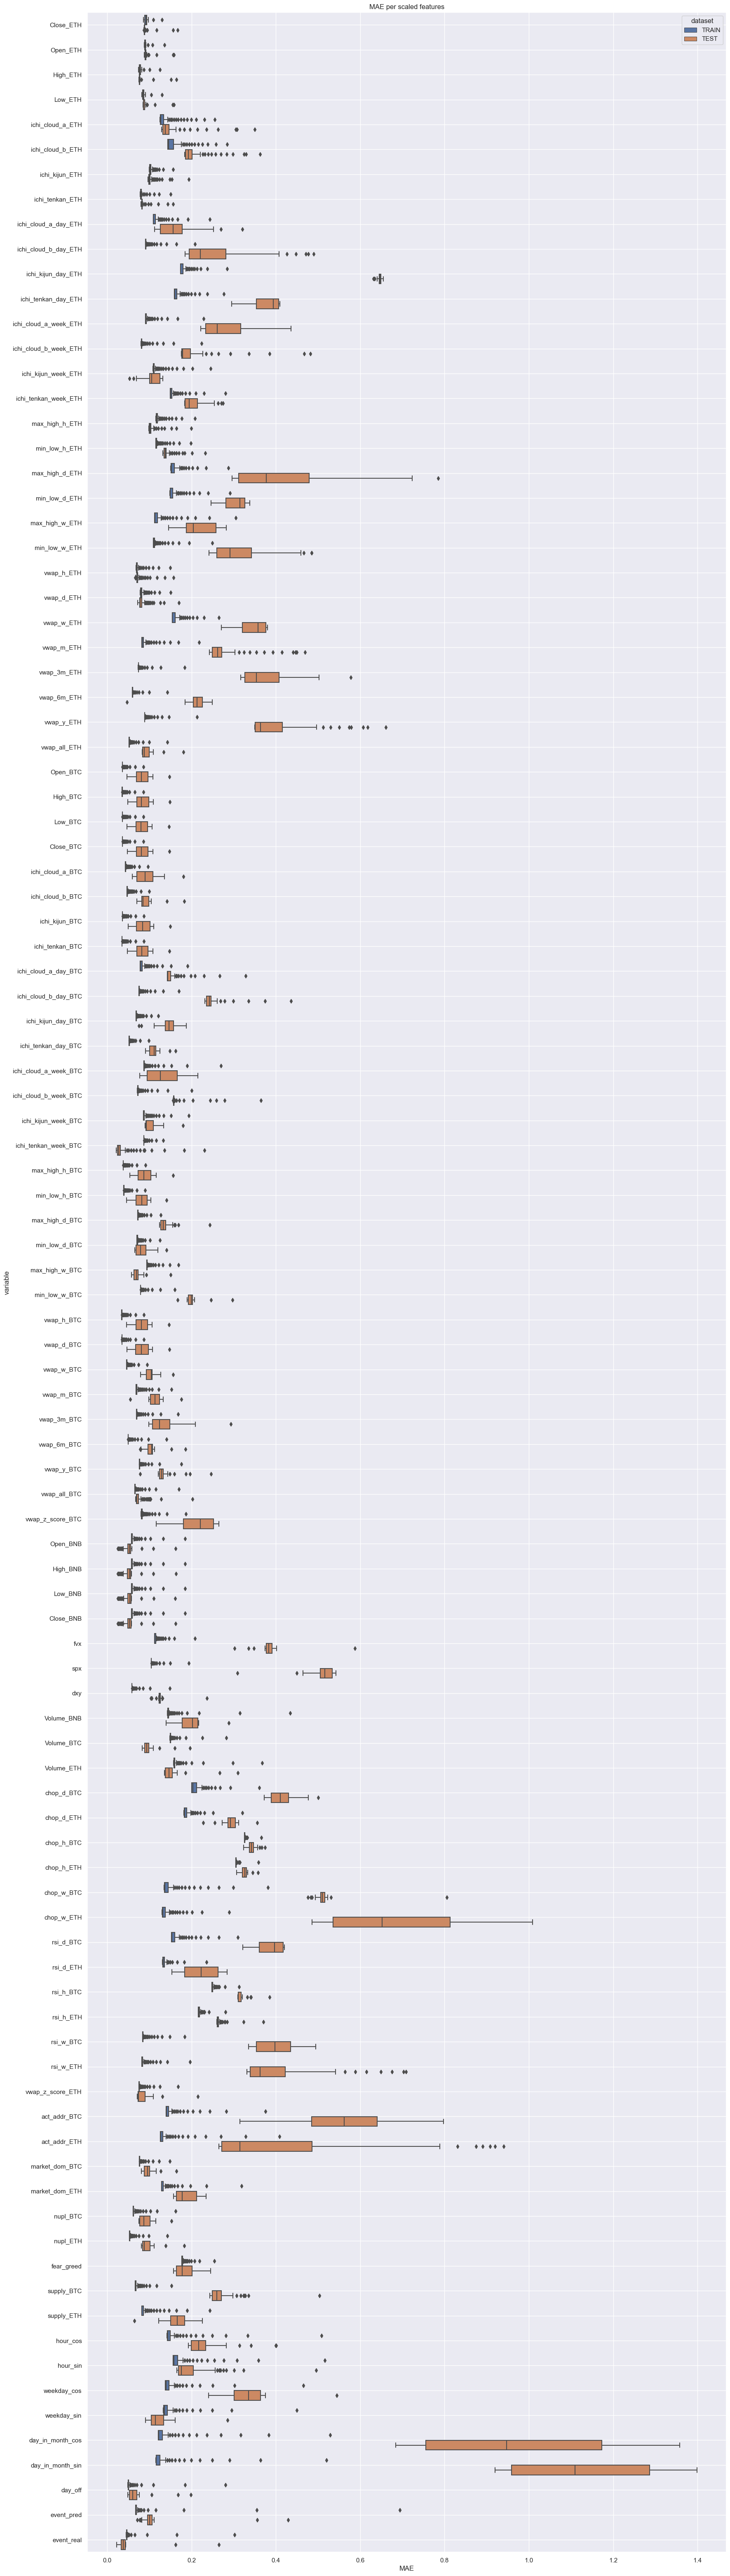

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [124]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(78891, 72, 102)
(78891, 72, 102)
(72, 102)
(710, 72, 102)
(710, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [125]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.020186  0.020017  0.014639  0.017201          0.067406   
0   0.019544  0.020129  0.012711  0.021464          0.045198   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.072884        0.025932         0.015770              0.023642   
0          0.073639        0.023787         0.015226              0.039691   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.016709  ...  0.042138  0.050169     0.039521     0.038818   
0              0.090001  ...  0.078053  0.056142     0.124818     0.023617   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.037384          0.034457  0.022372    0.468887    0.917689   
0          1.207782          1.500127  0.006509    0.019304    0.003597   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

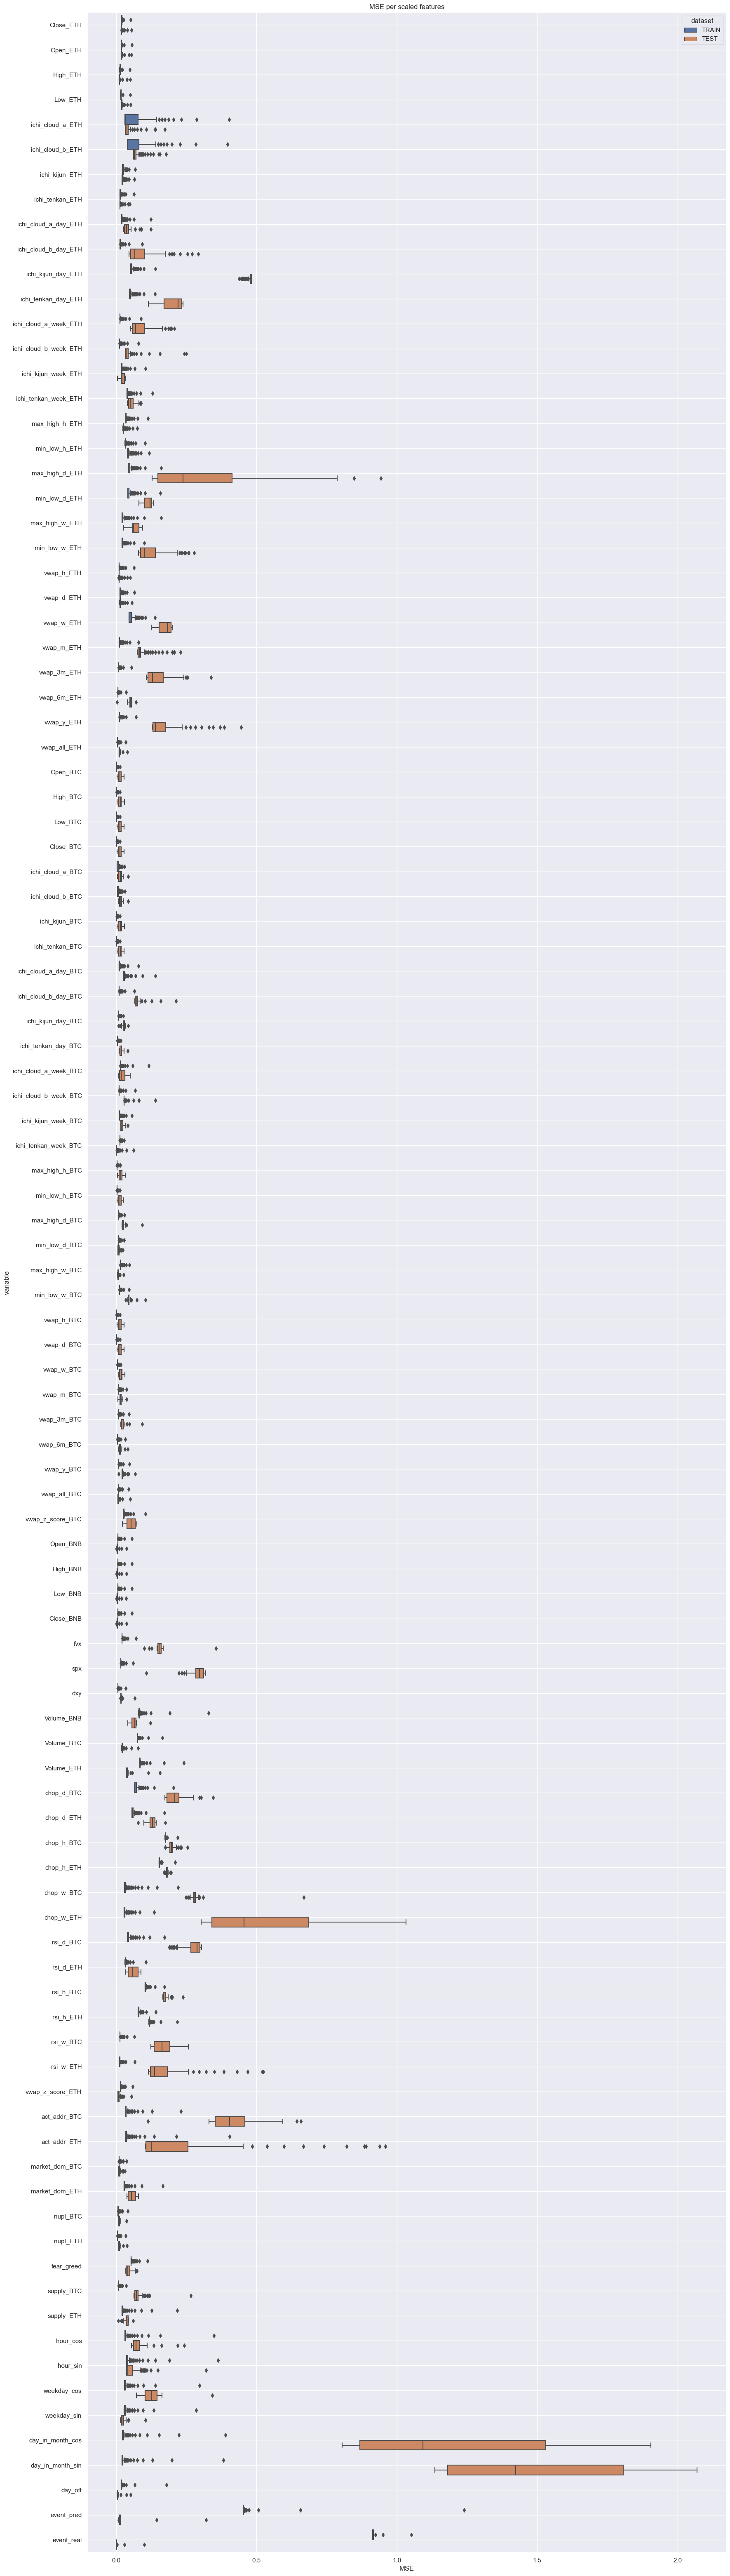

In [126]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

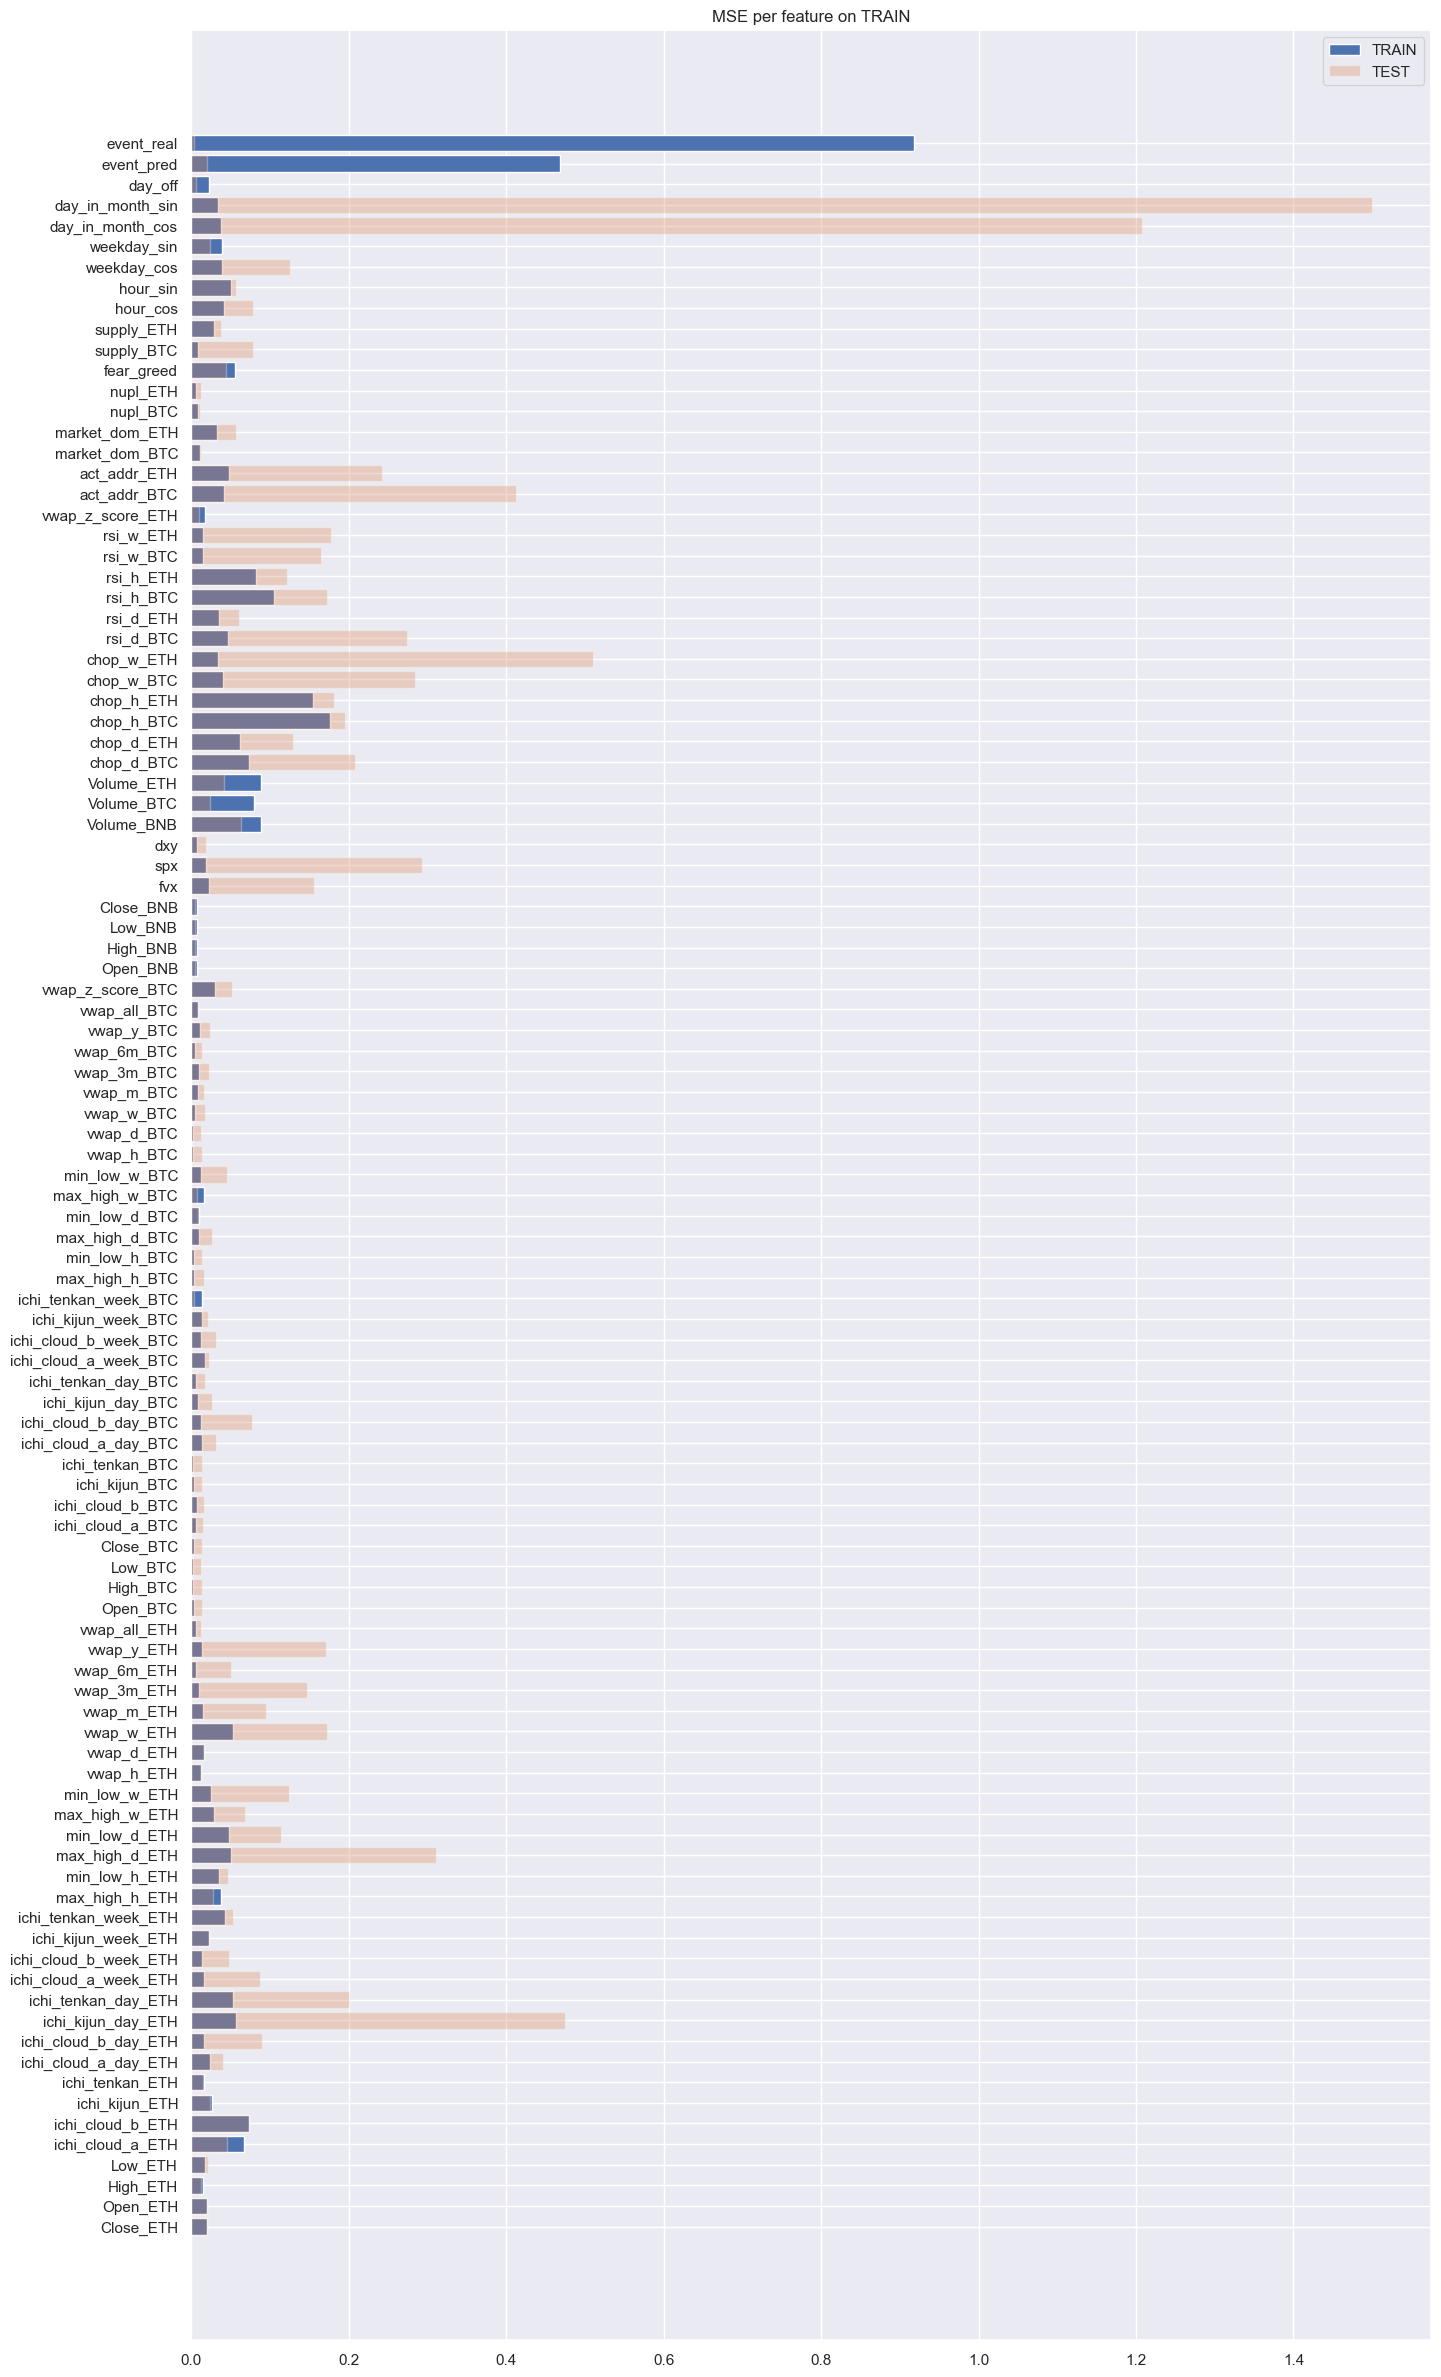

In [127]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [128]:
encoder_model.layers[3].get_weights()

[array([[ 0.14623028, -0.09850404, -0.36525813, ..., -0.3394282 ,
          0.1052024 ,  0.0639115 ],
        [ 0.08524565,  0.24465255,  0.24078368, ..., -0.18196481,
         -0.18465497,  0.49732402],
        [-0.54812   , -0.28807545, -0.43288934, ..., -0.04372569,
         -0.06728463,  0.11438002],
        ...,
        [-0.15885118, -0.06281347,  0.10925654, ...,  0.24000193,
         -0.29045352,  0.12284272],
        [-0.2917943 ,  0.17086793,  0.12735637, ..., -0.14883545,
         -0.23723416,  0.12699755],
        [ 0.13693558,  0.11752824,  0.1463657 , ..., -0.33025634,
         -0.03937227, -0.12203027]], dtype=float32),
 array([-0.09310412, -0.02308976, -0.2298859 , -0.29641214, -0.12508412,
        -0.56517327,  0.3534434 ,  0.25824267,  0.27212584,  0.2423331 ,
         0.18492478, -0.01830165, -0.11425388,  0.43537292,  0.15462741,
        -0.00125471], dtype=float32)]

## Prediction Models

### LSTM all features

In [129]:
X_train_sca.shape

(78891, 72, 102)

In [130]:
X_train_sca.shape[-1]

102

In [131]:
X_train_sca.shape[-2:]

(72, 102)

In [132]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [133]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [134]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2466/2466 [==============================] - 28s 11ms/step


(78891, 72, 16)

In [135]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

23/23 [==============================] - 0s 15ms/step


(710, 72, 16)

In [136]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [137]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [138]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [139]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((78891, 72, 20), (710, 72, 20))

#### Correlations

In [140]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



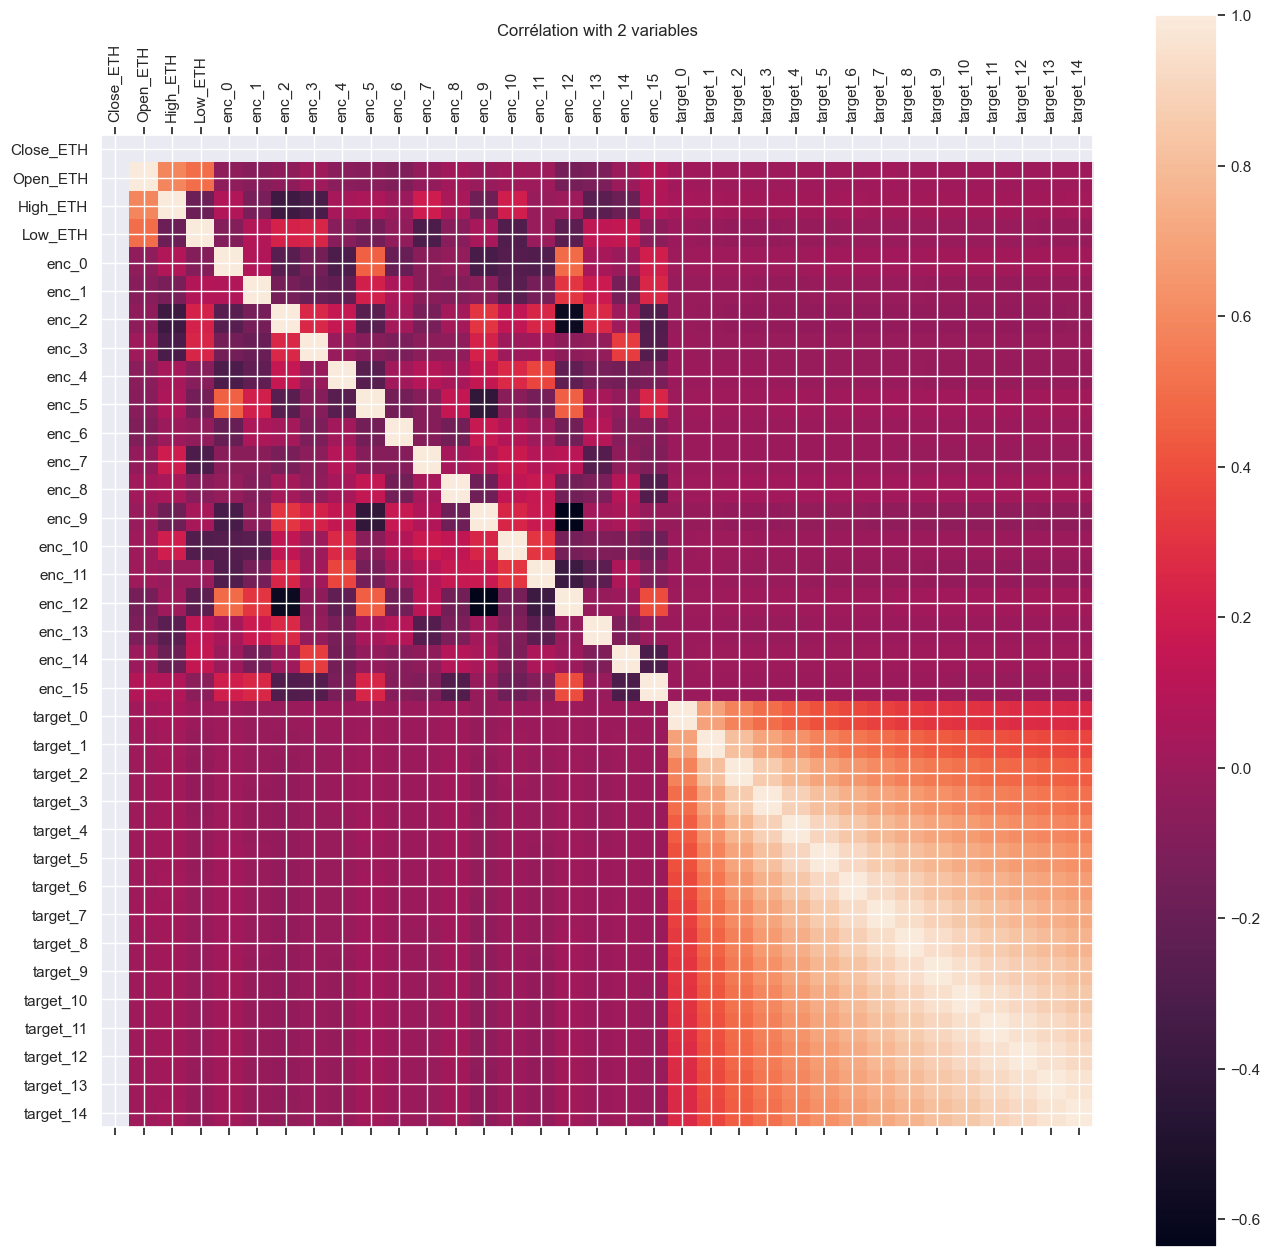

In [141]:
fig = plot_corr(corr_matrix_min)

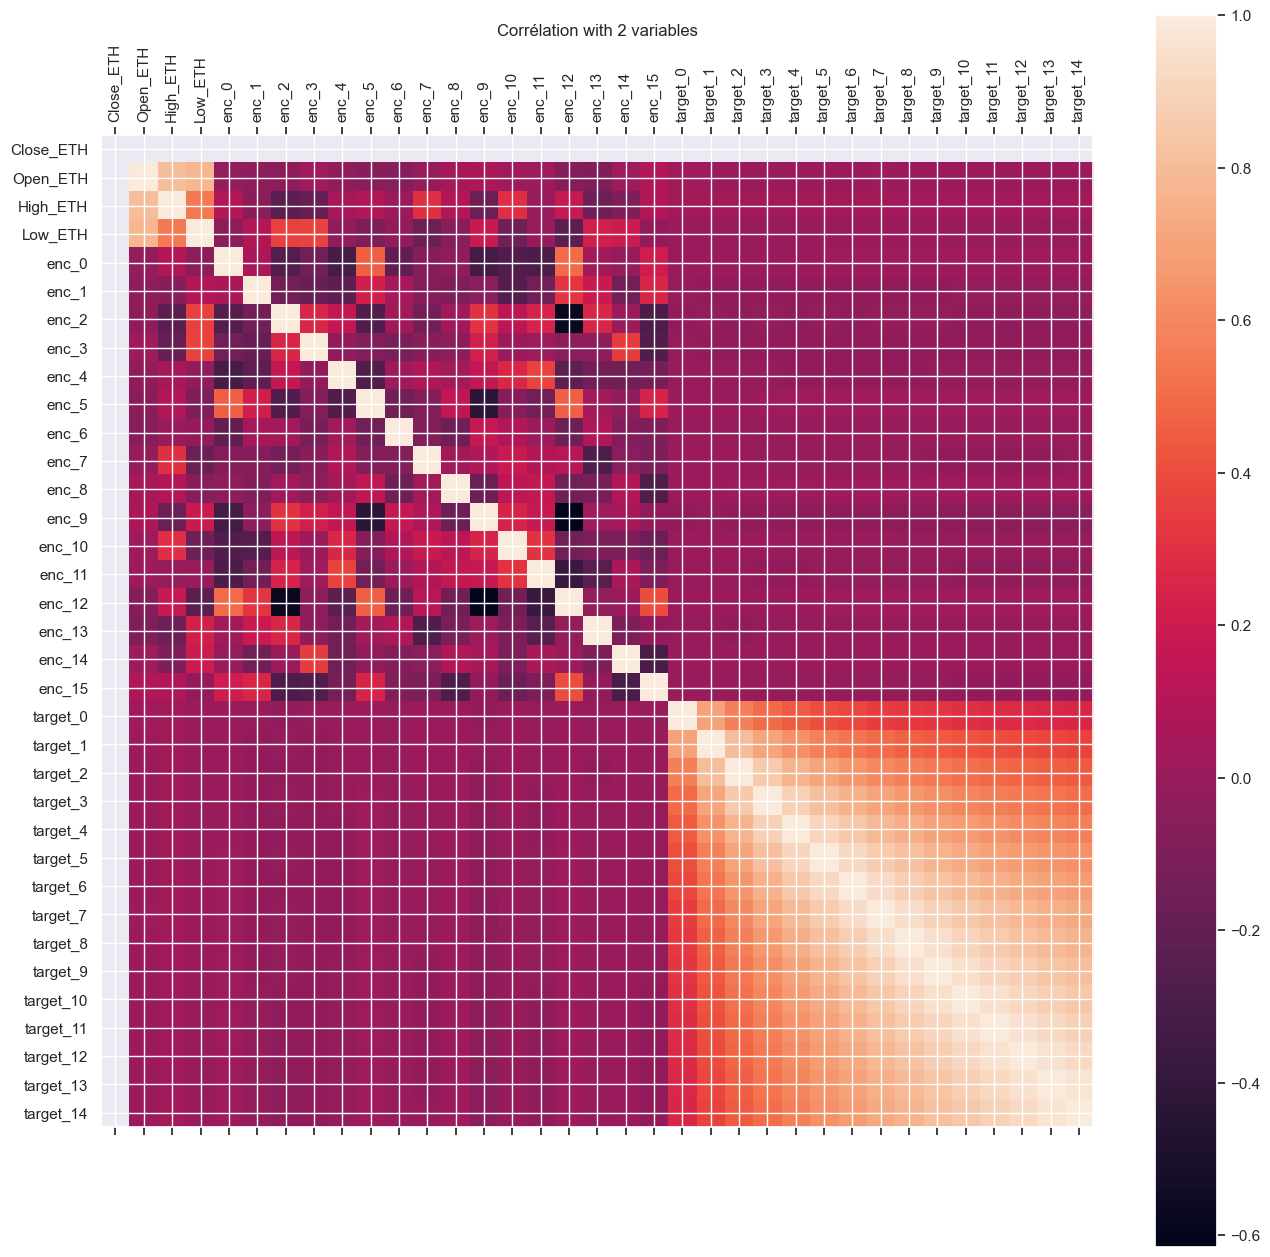

In [142]:
fig = plot_corr(corr_matrix_max) 

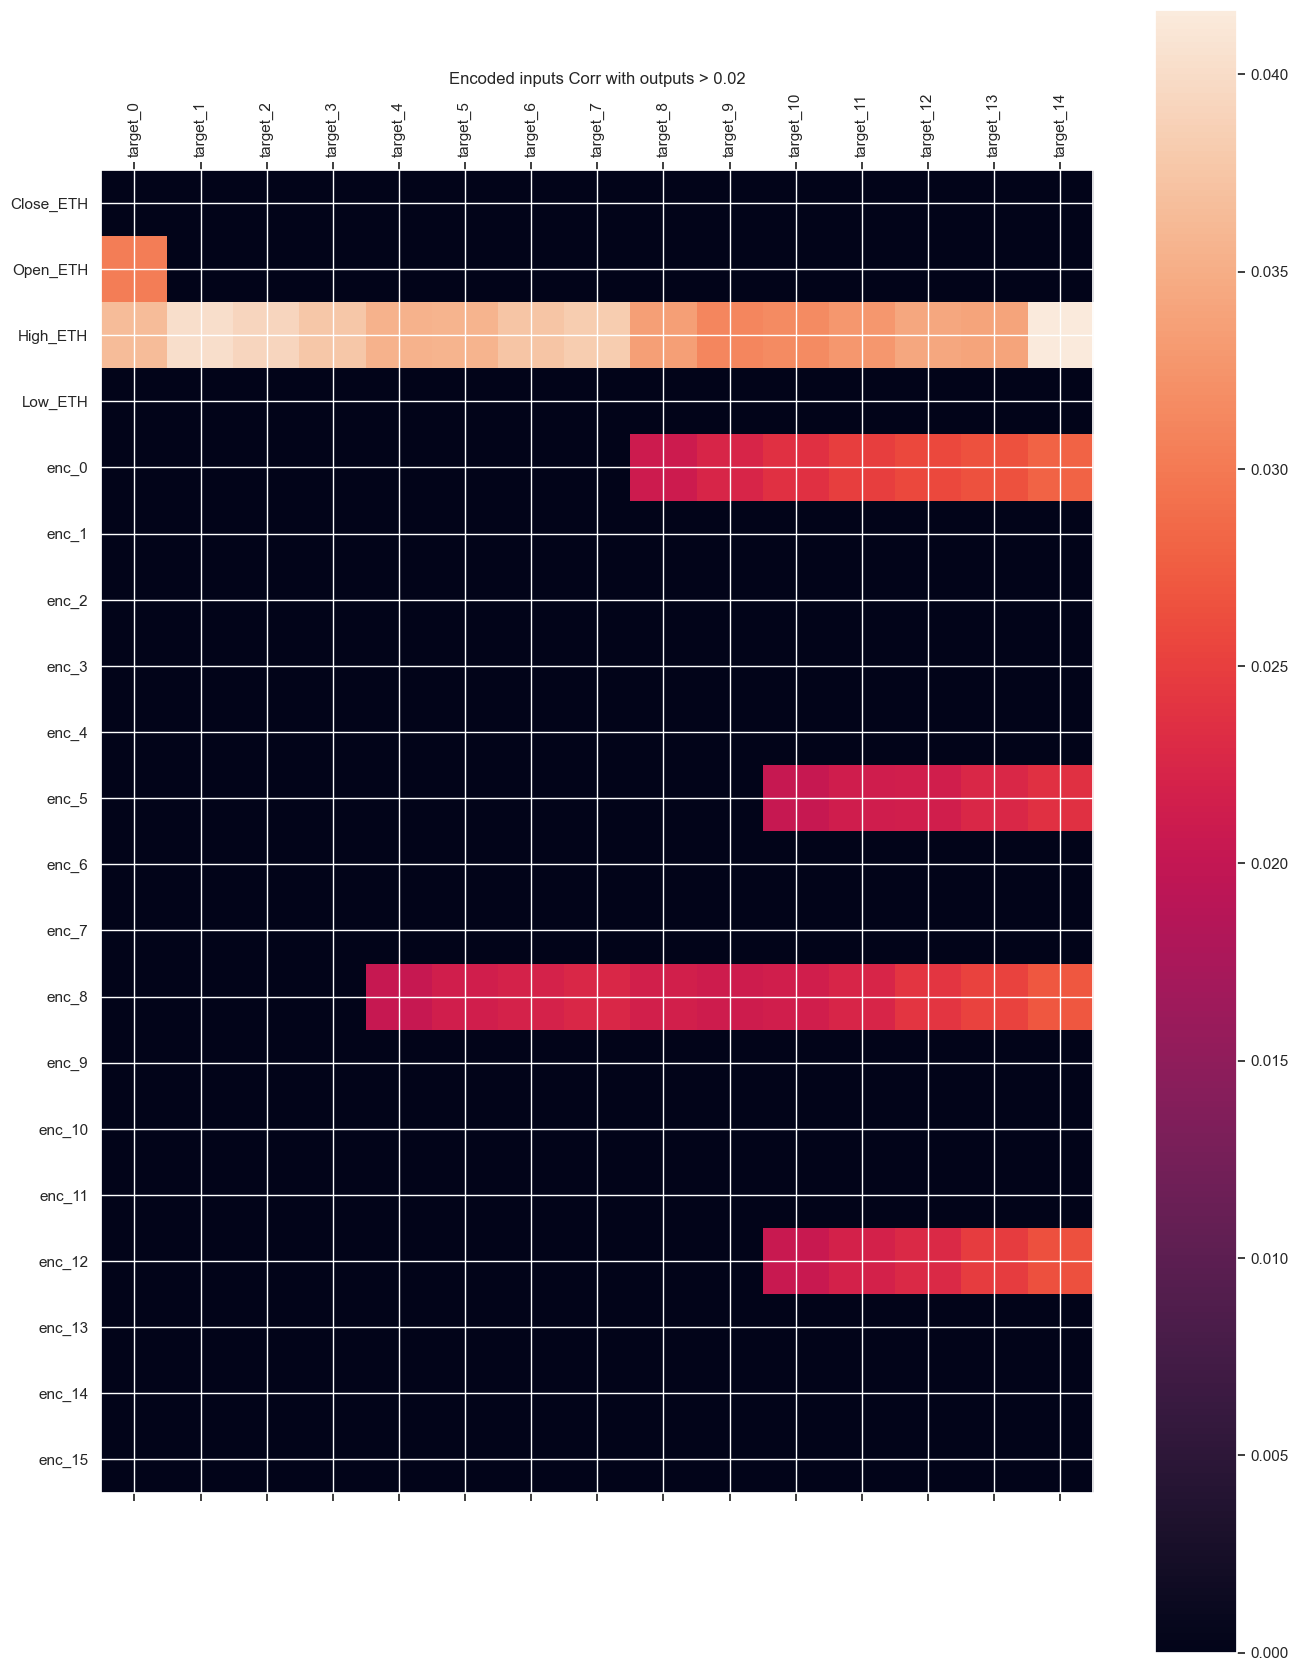

In [143]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

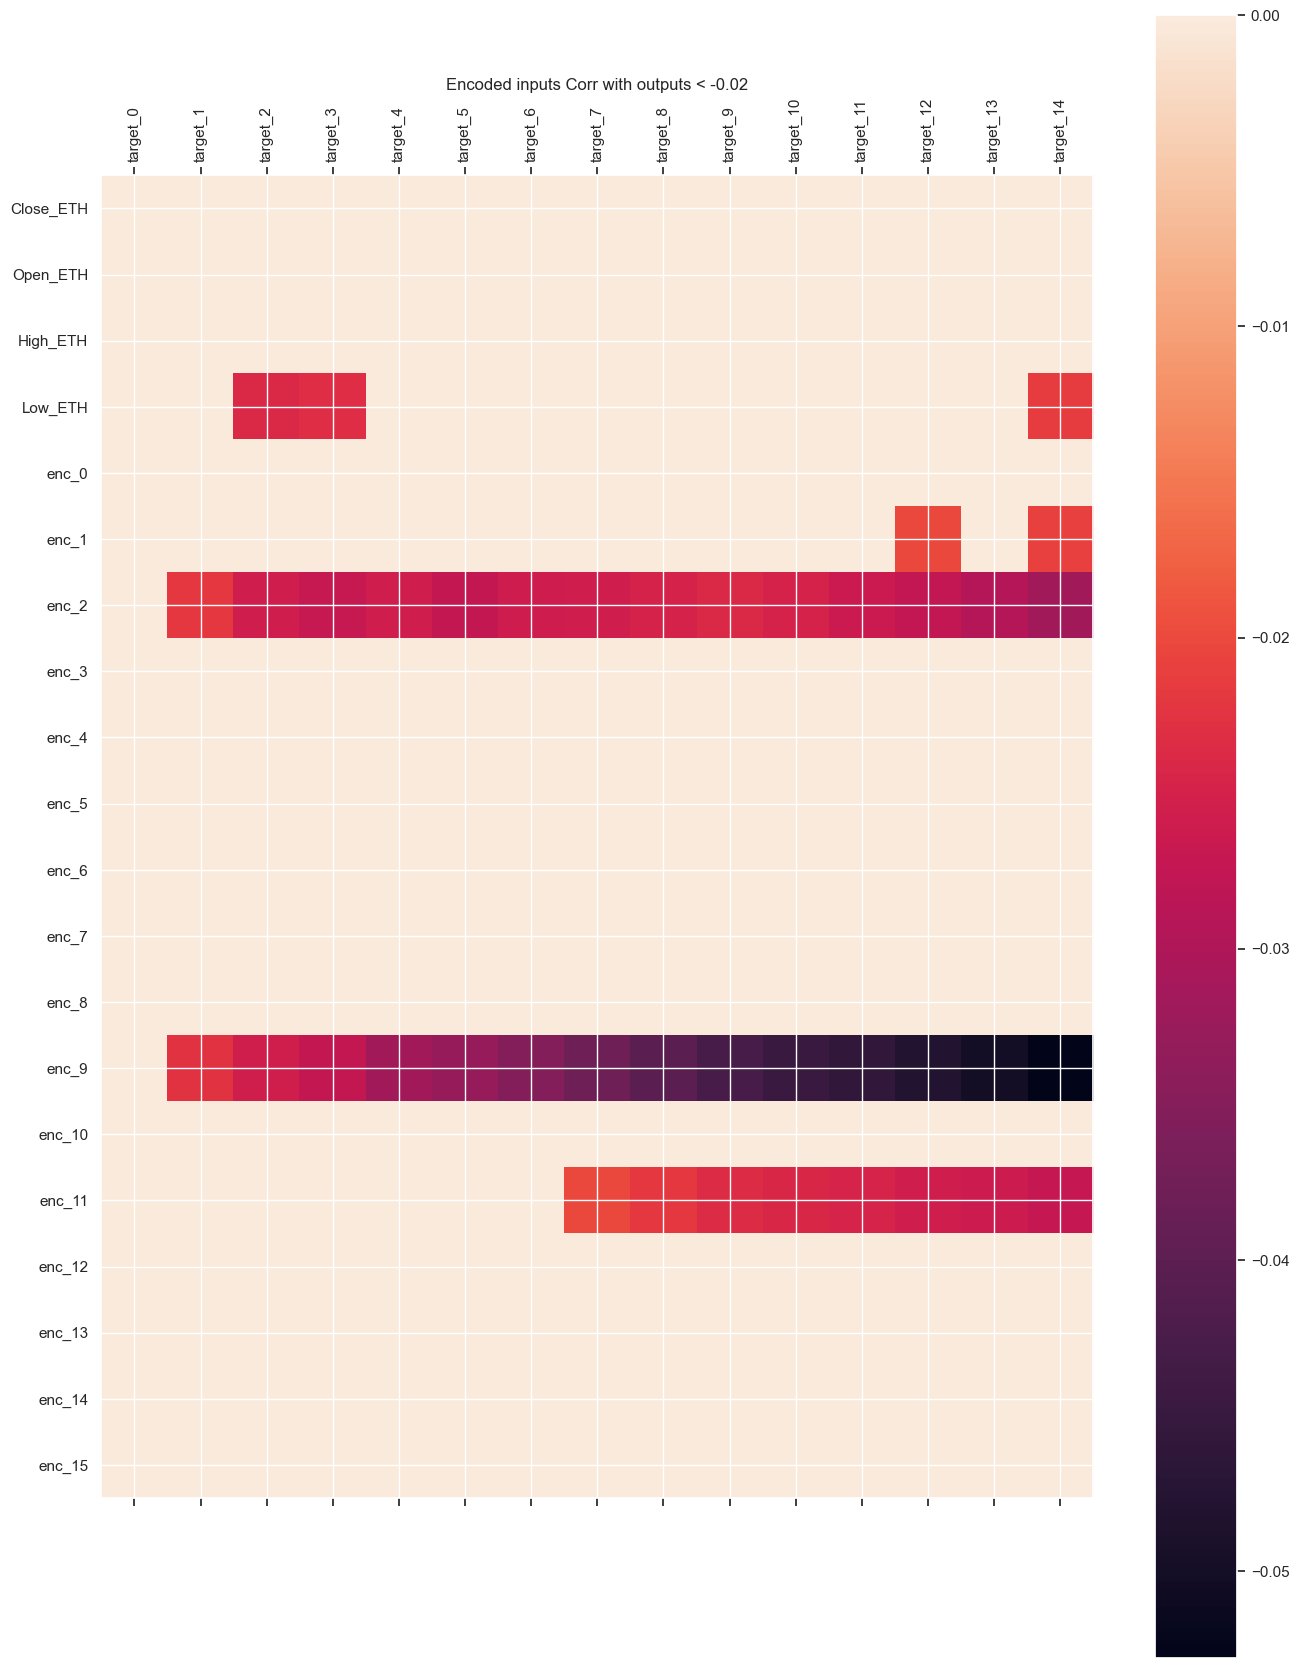

In [144]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [145]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [146]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [147]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [148]:
MODE_AUTO_SELECT

2

In [149]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 5, 8, 9, 11, 12]
nb encoded features:  8


In [150]:
X_train_.shape

(78891, 72, 20)

In [151]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  9, 12, 13, 15, 16])

In [152]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [153]:
X_train_.shape

(78891, 72, 12)

#### Train

In [154]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100#30
patience = 20#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            #optim = tf.keras.optimizers.AdamW()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 73871 (288.56 KB)
Trainable params: 73871 (288.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [155]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [156]:
np.min(y_train)

0.8990060972444147

In [157]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [158]:
X_train_.shape

(78891, 72, 12)

##### Predict

In [159]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

ValueError: in user code:

    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 72, 11), found shape=(None, 72, 12)


##### Plots

In [ ]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(78870,)
(78870,)


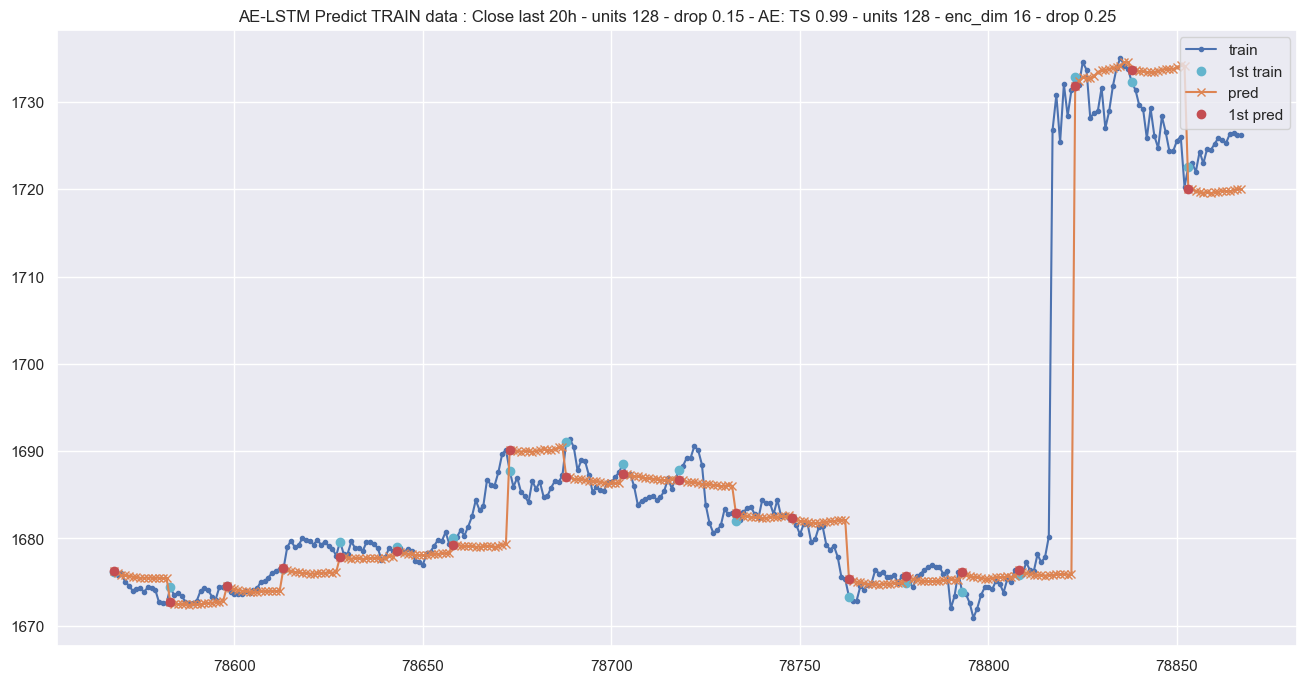

In [ ]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

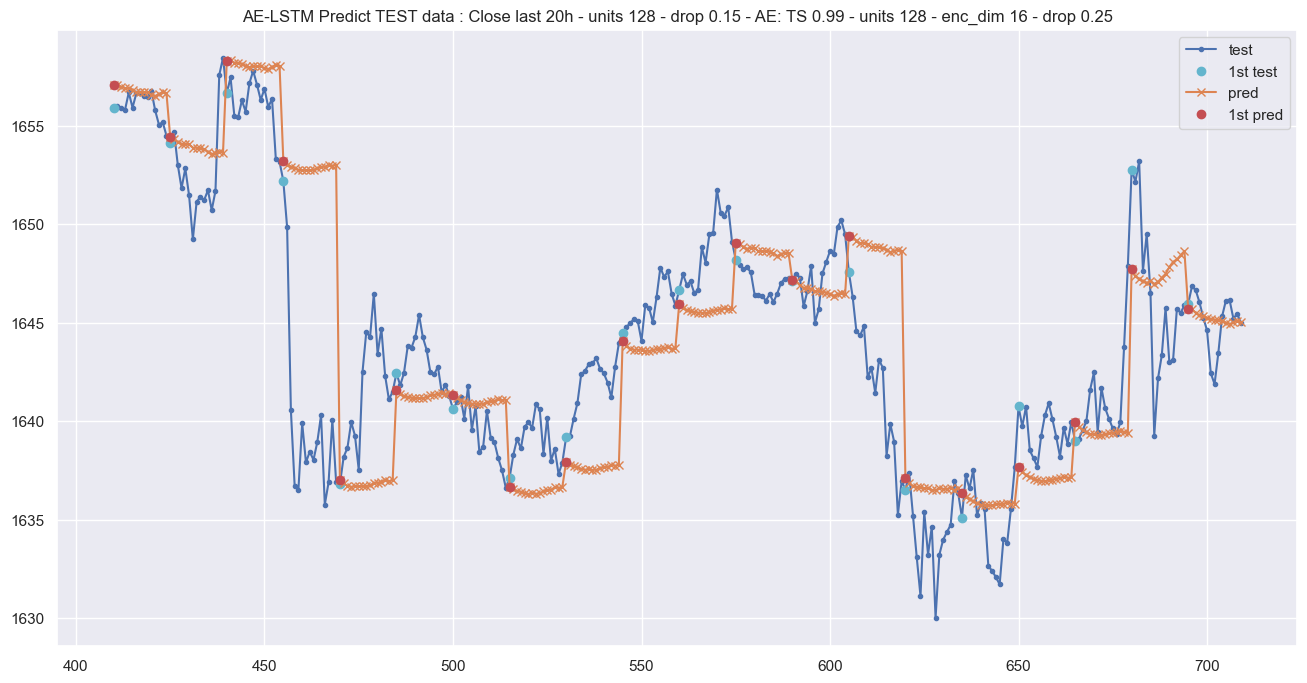

In [ ]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

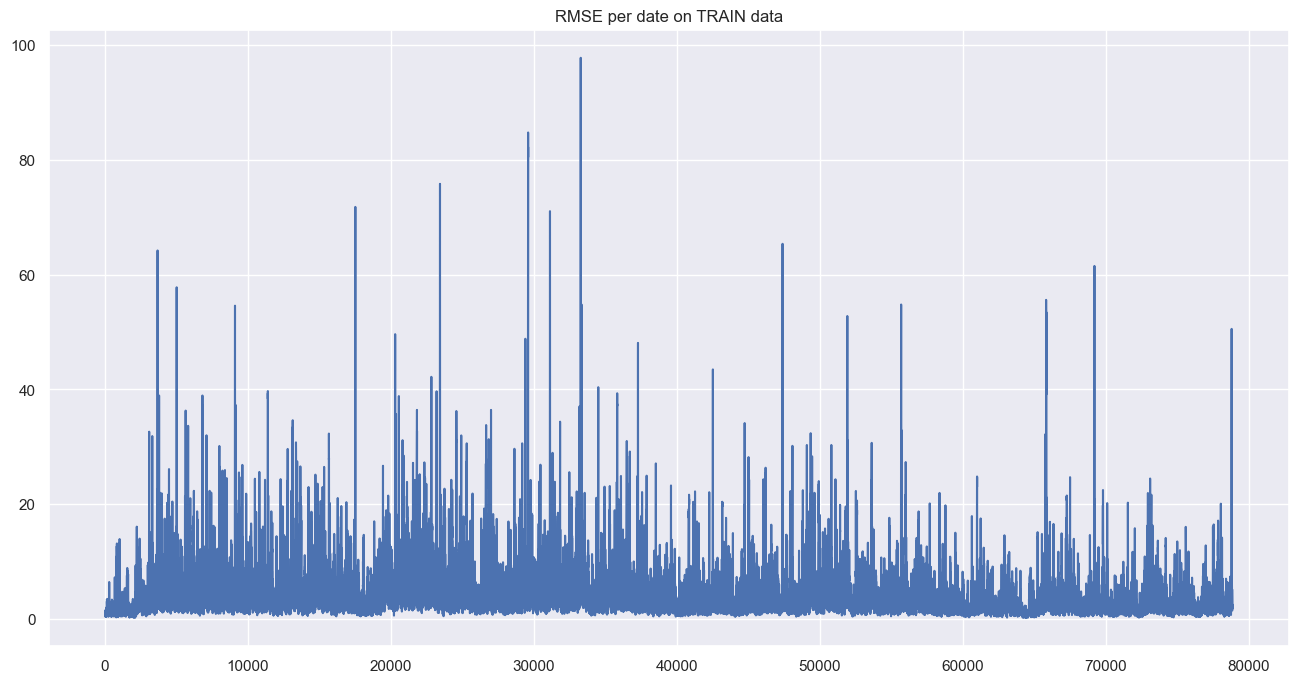

In [ ]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

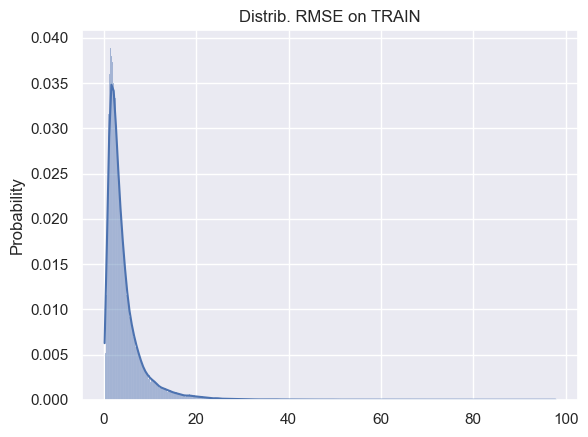

In [ ]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.37')

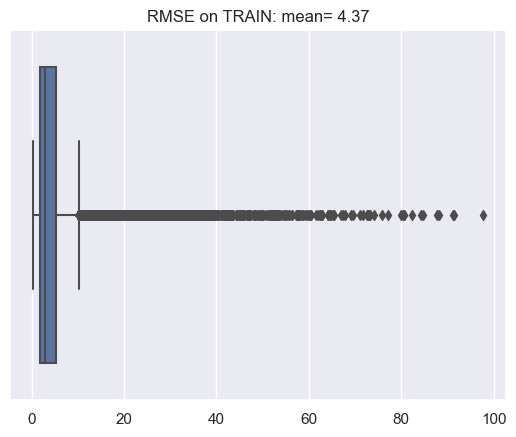

In [ ]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

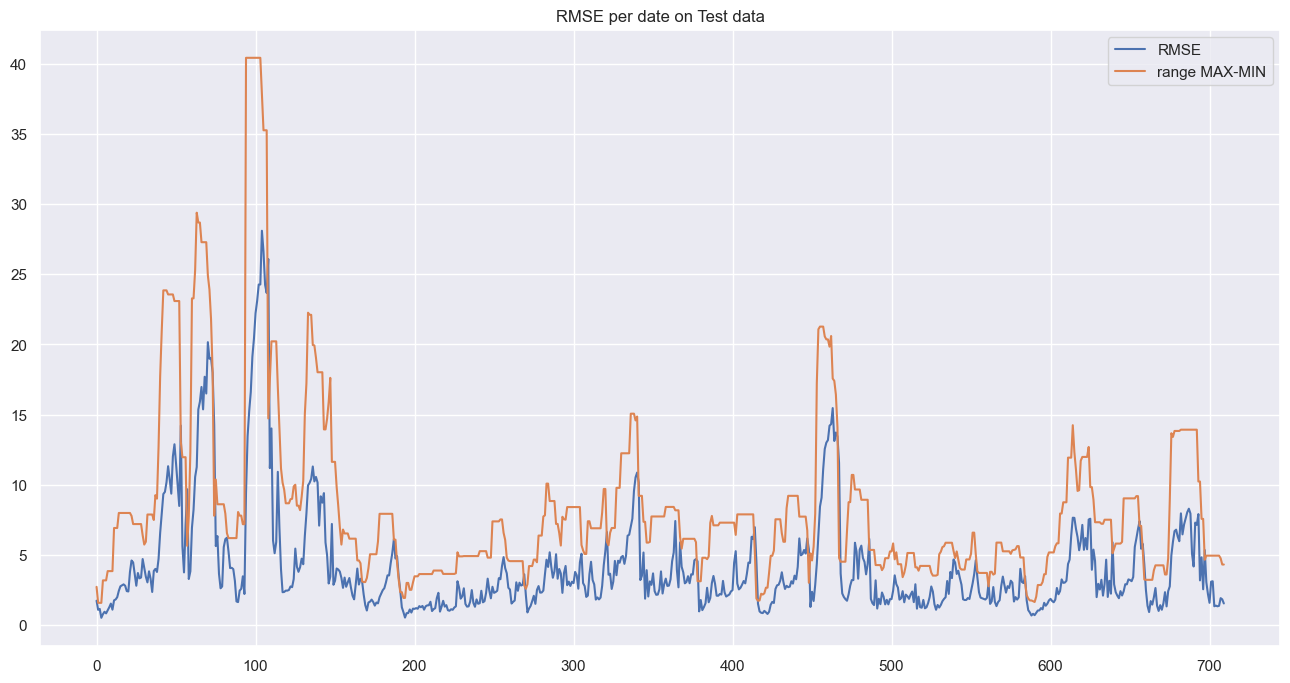

In [ ]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [ ]:
np.mean(arr_range)

8.535014084507033

<AxesSubplot: ylabel='Probability'>

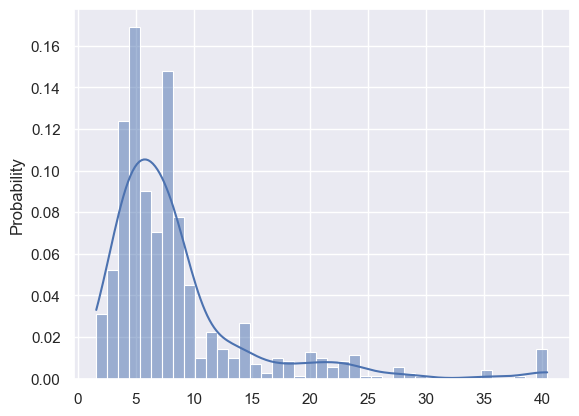

In [ ]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [ ]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

7.6311347020351015

<AxesSubplot: ylabel='Probability'>

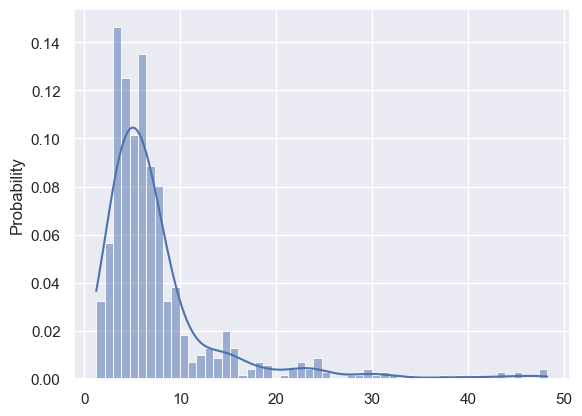

In [ ]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

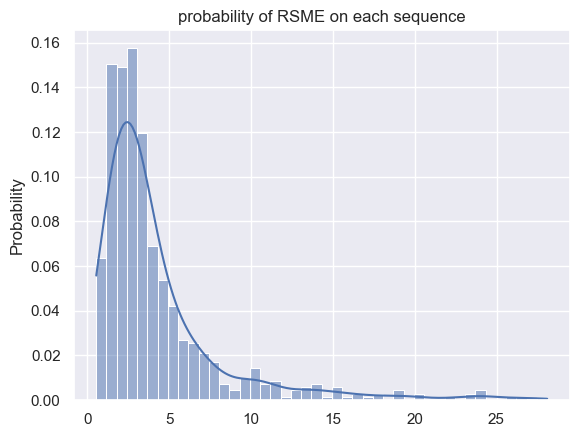

In [ ]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 42.675070422535164)

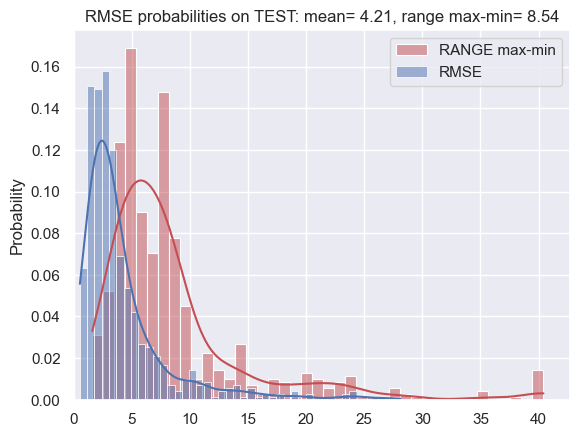

In [ ]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 21.063422894334497)

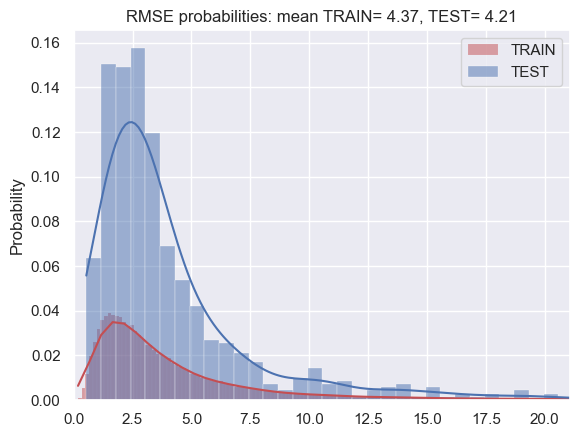

In [ ]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 4.21')

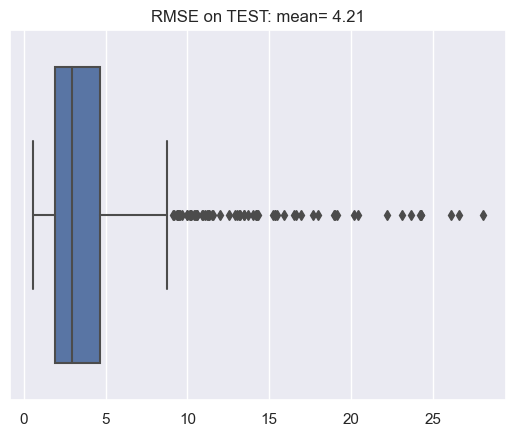

In [ ]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [ ]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1646.65 1646.03 1645.26 1644.61 1642.43 1641.88 1643.46 1645.32 1646.12
 1646.13 1645.2  1645.46 1644.96 1645.48 1646.21]
[1646.70620886 1646.7630431  1646.60353421 1646.54522758 1646.5111663
 1646.42076157 1646.32633231 1646.33928934 1646.28795202 1646.27470052
 1646.17879887 1646.10125301 1646.17487249 1646.25369442 1646.1965657 ]


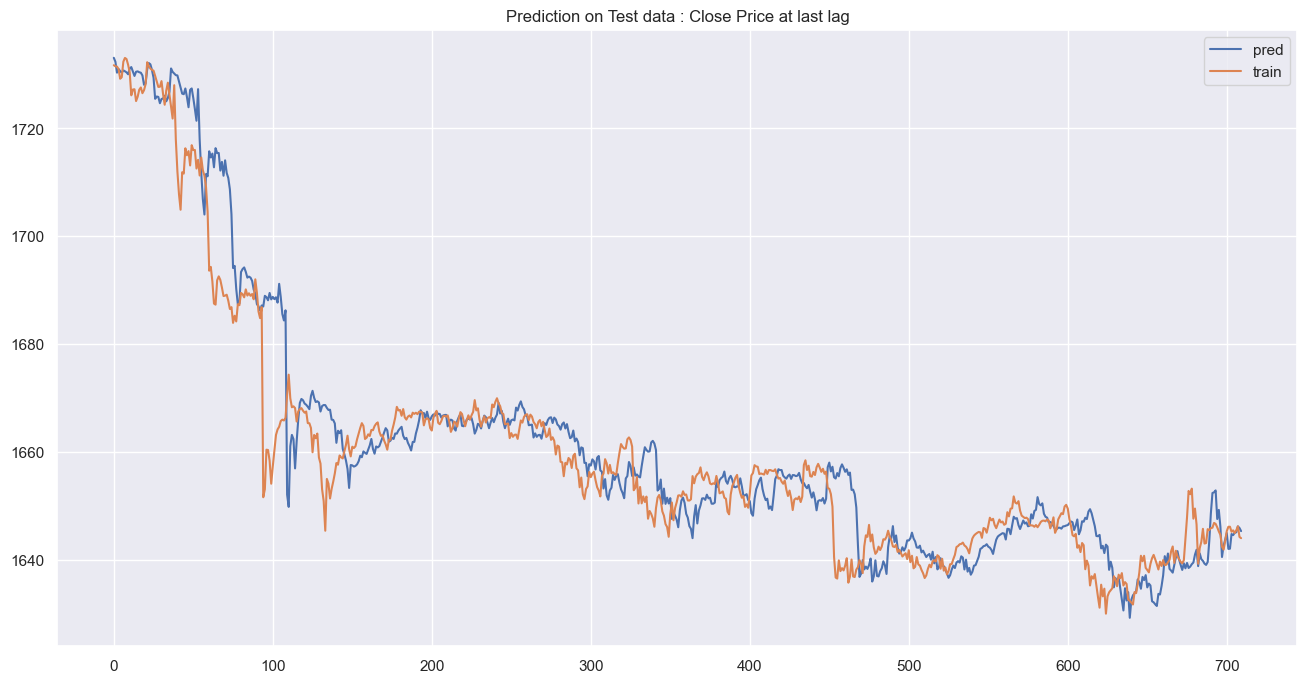

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

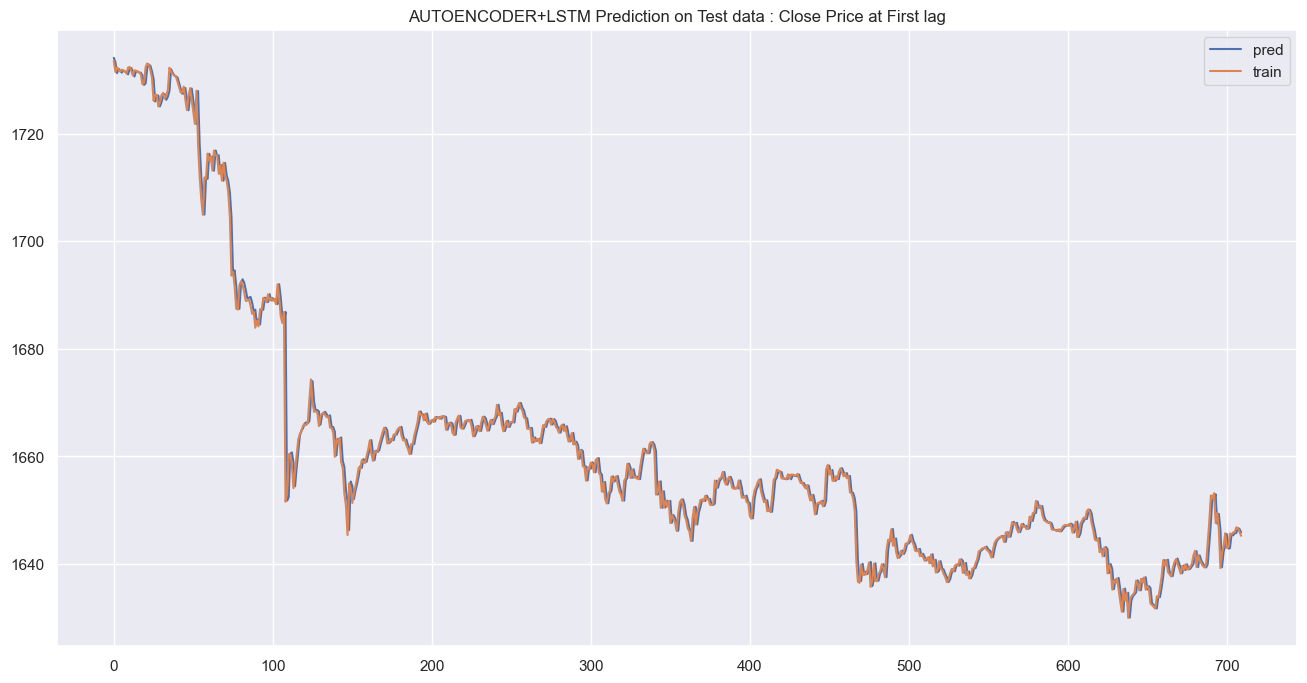

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

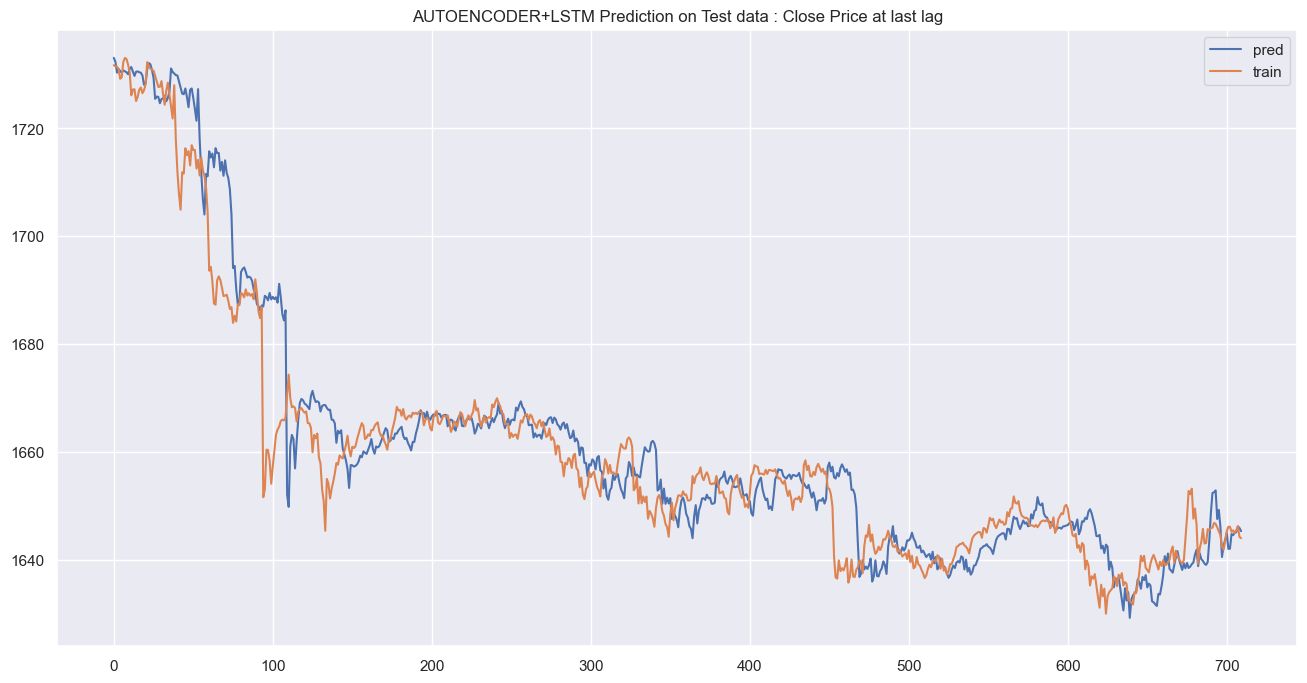

In [ ]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [ ]:
X_test_sca.shape

(710, 72, 102)

In [ ]:
df_feat["Close_ETH"].iloc[-1]

1644.01

In [ ]:
df_feat["Close_ETH"].iloc[-1]

1644.01

In [ ]:
len(list_i_enc_select)

7

In [ ]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1632.4  1632.07 1631.71 1634.01 1633.83 1635.56 1637.65 1640.75 1639.73
 1640.74 1638.51 1638.11 1637.67 1639.24 1640.29 1640.91 1640.09 1639.2
 1638.2  1639.67 1638.85 1639.95 1639.   1639.09 1639.53 1639.99 1641.59
 1642.47 1639.43 1641.68 1640.65 1640.12 1639.63 1639.35 1639.93 1643.77
 1647.87 1652.77 1652.16 1653.19 1647.63 1649.5  1646.53 1639.26 1642.17
 1643.34 1645.74 1643.01 1643.11 1645.68 1645.5  1645.88 1645.95 1646.84
 1646.65 1646.03 1645.26 1644.61 1642.43 1641.88 1643.46 1645.32 1646.12
 1646.13 1645.2  1645.46 1644.96 1645.48 1646.21 1644.24 1644.01 1644.01]
X_last[0,:,0] after divide by price:
[0.992938   0.99273727 0.99251829 0.99391731 0.99380782 0.99486013
 0.99613141 0.99801704 0.99739661 0.99801096 0.99665452 0.99641121
 0.99614358 0.99709856 0.99773724 0.99811437 0.99761559 0.99707423
 0.99646596 0.99736011 0.99686133 0.99753043 0.99695257 0.99700732
 0.99727496 0.99755476 0.99852799 0.99906327 0.99721413 0.99858273
 0.99

In [ ]:
X_last_encoded_sca.shape

(1, 72, 16)

In [ ]:
list_i_enc_select

[0, 2, 8, 9, 10, 11, 12]

In [ ]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 7)

In [ ]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [ ]:
X_train_.shape

(78868, 72, 11)

In [ ]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
79747  1696455300000   1644.96   1648.09  1644.96    1645.48    653.0074   
79748  1696455600000   1645.47   1646.50  1645.43    1646.21    520.7596   
79749  1696455900000   1646.22   1646.22  1644.24    1644.24    530.3278   
79750  1696456200000   1644.24   1644.25  1644.01    1644.01    105.0287   
79751  1696456500000   1644.02   1644.02  1644.01    1644.01     57.1545   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1734.081801       1733.644602   
1      2023-01-01 00:05:00       1734.081801       1733.644602   
2      2023-01-01 00:10:00       1734.081801       1733.644602   
3      2023-01-01 00:15:00       1734.081801       1733.644602   
4      2023-01-01 00:20:00       1734.081801       1733.644602   
...                    ...               ...               ...   
79747  2023-10-04 21:35:00       1646.475000       1643.255000   
79748  2023-10-04 21:40:00       1646.575000       1643.255000   
79749  2023-10-04 21:45:00       1646.082500       1643.255000   
79750  2023-10-04 21:50:00       1646.090000       1643.255000   
79751  2023-10-04 21:55:00       1646.090000       1643.255000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
79747        1643.575  ...         NaN            NaN           NaN   
79748        1642.730  ...         NaN            NaN           NaN   
79749        1642.805  ...         NaN            NaN           NaN   
79750        1644.345  ...         NaN            NaN           NaN   
79751        1644.345  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
79747               NaN         0.0               NaN         0.0      0.0   
79748               NaN         0.0               NaN         0.0      0.0   
79749               NaN         0.0               NaN         0.0      0.0   
79750               NaN         0.0               NaN         0.0      0.0   
79751               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
79747                  NaN  False  
79748                  NaN  False  
79749                  NaN  False  
79750                  NaN  False  
79751                  NaN  False  

[79752 rows x 136 columns]

In [ ]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [ ]:
y_last_pred_unscaled

array([[0.99993885, 0.999955  , 0.99984294, 0.9997747 , 0.99977225,
        0.99973506, 0.9996672 , 0.9996743 , 0.9996467 , 0.9996382 ,
        0.9995808 , 0.9995325 , 0.9995781 , 0.9996159 , 0.9995918 ]],
      dtype=float32)

In [ ]:
df_feat["Close_ETH"].iloc[-1]

1644.01

In [ ]:
y_last_pred_raw

array([[1643.9094, 1643.936 , 1643.7518, 1643.6396, 1643.6356, 1643.5745,
        1643.4629, 1643.4746, 1643.4292, 1643.4152, 1643.3208, 1643.2415,
        1643.3164, 1643.3785, 1643.339 ]], dtype=float32)

In [ ]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [ ]:
list_pred

[1643.6396,
 1643.6356,
 1643.5745,
 1643.4629,
 1643.4746,
 1643.4292,
 1643.4152,
 1643.3208,
 1643.2415,
 1643.3164,
 1643.3785,
 1643.339]

In [ ]:
save_list(list_pred, path_save_pred_vals)

In [ ]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [ ]:
list_pred_reload

[1643.6396,
 1643.6356,
 1643.5745,
 1643.4629,
 1643.4746,
 1643.4292,
 1643.4152,
 1643.3208,
 1643.2415,
 1643.3164,
 1643.3785,
 1643.339]